## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np 
import cv2 
import glob 
import matplotlib.pyplot as plt
%matplotlib inline

## Camera calibration 

In [2]:

def camera_calibration(nx,ny):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [3]:
def calc_distort(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist 

In [ ]:
image = cv2.imread("../camera_cal/calibration1.jpg")
nx = 9 
ny = 6
mtx, dist = camera_calibration(nx,ny)
undist = calc_distort(image, mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(undist) 
ax2.set_title('Undistorted Image', fontsize=10)
 

In [ ]:
image = cv2.imread("../test_images/test1.jpg")
nx = 9 
ny = 6
mtx, dist = camera_calibration(nx,ny)
undist = calc_distort(image, mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist) 
ax2.set_title('Undistorted Image', fontsize=50)

### Color and gradient threshold

In [4]:
# Gradient calculation 
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [ ]:
image = cv2.imread("../test_images/test1.jpg")
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# Magnitude of the gradient 
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):  
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobel_kernel) 
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(mag)/255 
    mag = (mag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(mag)
    # 6) Return this mask as your binary_output image
    binary_output[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    return binary_output

In [ ]:
image = cv2.imread("../test_images/test1.jpg")
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


In [ ]:
image = cv2.imread("../test_images/test1.jpg")    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

####  RGB and HLS channel images 

In [ ]:
image = cv2.imread("../test_images/test1.jpg")   
R_channel = image[:,:,0]
#plt.imshow(R_channel)
G_channel = image[:,:,1]
#plt.imshow(G_channel)
B_channel = image[:,:,2]
plt.imshow(B_channel)


In [ ]:
image = cv2.imread("../test_images/test1.jpg")  
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
plt.imshow(h)

In [ ]:
l = hls[:,:,1]
plt.imshow(l)

In [ ]:
s = hls[:,:,2]
plt.imshow(s)

In [7]:
### Combined color and gradient 
def combined_color(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary 

####  Combined thresholded image 

In [ ]:
image = cv2.imread("../test_images/test1.jpg")
mtx,dist= camera_calibration(9,6)
undist = calc_distort(image,mtx,dist)
result_color,result_combined = combined_color(undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 50)
ax2.imshow(result_combined)
ax2.set_title("Thresholded Image", fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a perspective transform

In [8]:
src = np.asarray([[240, 686], [1060, 686], [738, 480], [545 ,480]], np.float32)
dst = np.asarray([[300, 700], [1000, 700], [1000 , 300], [300, 300]], np.float32)
def perspective_transform(image,nx = 9):
    offset = 100
    img_size = (image.shape[1], image.shape[0])
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     #[img_size[0]-offset, img_size[1]-offset], 
                                     #[offset, img_size[1]-offset]]) 
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [ ]:
image = cv2.imread("../test_images/test1.jpg")
mtx,dist = camera_calibration(9,6)
undist = calc_distort(image,mtx,dist)
_,thres = combined_color(undist)
result = perspective_transform(thres)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 50)
ax2.imshow(result)
ax2.set_title("Thresholded Image", fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###  Image preprocessing

In [9]:
nx = 9
ny = 6
#camera calibration
mtx,dist =camera_calibration(nx,ny)

In [10]:
def pre_process(img):
    #Undistort the image 
    undist = calc_distort(img,mtx,dist)
    #Thresholded image 
    result_color,result_combined = combined_color(undist)
    #Perspective transform 
    pers_result = perspective_transform(result_combined) 
    return pers_result 

In [ ]:
image = cv2.imread("../test_images/test1.jpg")
pers_result  = pre_process(image)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 50)
ax2.imshow(pers_result)
ax2.set_title("Preprocessed Image", fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect Lane pixels and fit the lane boundary 

In [11]:
# Define a class to receive the characteristics of each line detection
from collections import deque
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None       
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        self.recent_fits = deque(maxlen=30)
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [23]:
def find_lanes(binary_warped,image,left_line, right_line):
       
    if left_line.detected == False & right_line.detected == False:
      
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
                
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
                
  
        left_line.detected = True
        right_line.detected = True
        
        left_line.current_fit = left_fit 
        right_line.current_fit = right_fit 
        
    else:
       
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Radius of curvature 
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

     # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
               
    
    Minv = cv2.getPerspectiveTransform(dst,src)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curvature = (left_curverad + right_curverad) / 2
    cv2.putText(result, "Curvature: {0:.2f}m".format(curvature), (30,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)

    bottom_leftx = left_fitx[-1]
    bottom_rightx = right_fitx[-1]

    lane_center = (bottom_leftx + bottom_rightx) / 2

    car_center = 1280 / 2

    difference = lane_center - car_center

    difference_meters = difference * xm_per_pix

    if difference < 0:
        cv2.putText(result, "{0:.2f}m right of center".format(difference_meters), (30,110), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)
    else:
        cv2.putText(result, "{0:.2f}m left of center".format(difference_meters), (30,110), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), thickness=10)
        

    return result


In [24]:
def pipeline(image,plot=False):
    pers_result  = pre_process(image)
    #result = fit_poly(pers_result, image, left_line, right_line,plot)
    result = find_lanes(pers_result,image, left_line, right_line)
    return result 
  


914.278773782 m 699.601897707 m


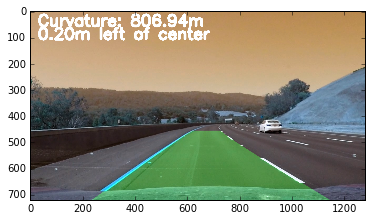

In [28]:
image = cv2.imread("../test_images/test3.jpg")
left_line = Line()
right_line = Line()
result = pipeline(image)
plt.imshow(result)

873.238963259 m 1526.50709954 m


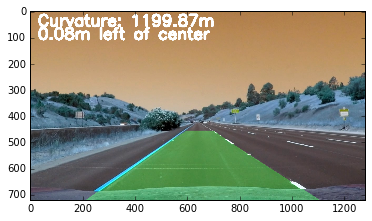

832.947793604 m 1885.18614251 m


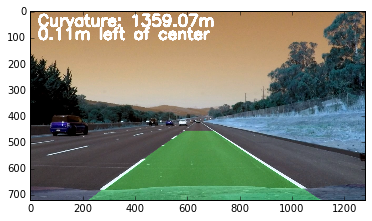

522.072392641 m 798.039331633 m


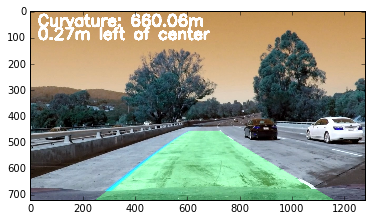

3982.30481498 m 416.511407541 m


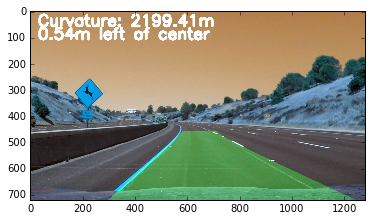

914.278773784 m 699.601897707 m


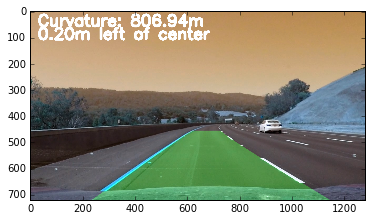

3330.9437743 m 653.167699189 m


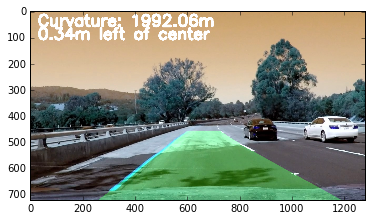

5335.22684799 m 769.01158917 m


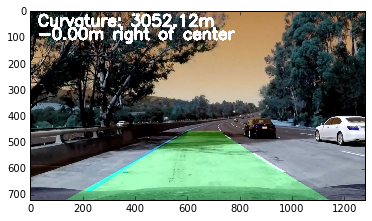

990.203629705 m 588.250209137 m


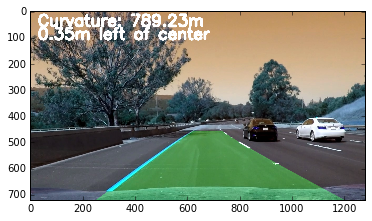

In [30]:
test_images = glob.glob('../test_images/*.jpg')
for image in test_images:
    image = cv2.imread(image)
    result = pipeline(image)
    plt.imshow(result)
    plt.show()

In [27]:
from moviepy.editor import *
out_video = "video_output.mp4"
left_line = Line()
right_line = Line()
video = VideoFileClip("project_video.mp4")
clip = video.fl_image(pipeline) 
%time clip.write_videofile(out_video, audio=False,verbose=False)




  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<02:49,  7.42it/s]

589.646734389 m 692.132568038 m
589.646734389 m 692.132568038 m





  0%|          | 2/1261 [00:00<02:47,  7.52it/s]


  0%|          | 3/1261 [00:00<02:45,  7.60it/s]

562.026631474 m 619.553010366 m
526.504213012 m 868.304177588 m





  0%|          | 4/1261 [00:00<02:42,  7.75it/s]


  0%|          | 5/1261 [00:00<02:41,  7.79it/s]

534.176968087 m 804.23580432 m
521.85131617 m 868.635546645 m





  0%|          | 6/1261 [00:00<02:39,  7.88it/s]


  1%|          | 7/1261 [00:00<02:40,  7.81it/s]

513.283290485 m 786.661500378 m
562.409083076 m 677.398912341 m





  1%|          | 8/1261 [00:01<02:39,  7.86it/s]


  1%|          | 9/1261 [00:01<02:39,  7.83it/s]

556.524123605 m 624.008327437 m
604.646614172 m 912.817827299 m





  1%|          | 10/1261 [00:01<02:39,  7.84it/s]

612.446192315 m 873.970419523 m
661.158135692 m 766.343221825 m





  1%|          | 11/1261 [00:01<03:02,  6.83it/s]


  1%|          | 12/1261 [00:01<03:31,  5.91it/s]

658.543710792 m 764.077220771 m





  1%|          | 13/1261 [00:01<03:54,  5.32it/s]

700.527922698 m 1873.41704468 m





  1%|          | 14/1261 [00:02<04:08,  5.02it/s]

755.463763363 m 1325.85175316 m





  1%|          | 15/1261 [00:02<04:20,  4.78it/s]

753.593459001 m 1339.89427236 m





  1%|▏         | 16/1261 [00:02<05:42,  3.63it/s]

725.654517956 m 1220.72757826 m





  1%|▏         | 17/1261 [00:03<05:45,  3.60it/s]

711.688413444 m 1190.61902707 m





  1%|▏         | 18/1261 [00:03<05:51,  3.54it/s]

713.039287432 m 46799.1850396 m





  2%|▏         | 19/1261 [00:03<05:33,  3.73it/s]


  2%|▏         | 20/1261 [00:03<04:40,  4.42it/s]

749.213178025 m 4431.09600897 m
780.179067857 m 23382.8219615 m





  2%|▏         | 21/1261 [00:03<04:20,  4.76it/s]

857.302744485 m 570.265886421 m





  2%|▏         | 22/1261 [00:04<04:18,  4.80it/s]


  2%|▏         | 23/1261 [00:04<03:45,  5.48it/s]

892.289503462 m 417.540544253 m
887.375040982 m 488.780224522 m





  2%|▏         | 24/1261 [00:04<03:24,  6.05it/s]


  2%|▏         | 25/1261 [00:04<03:09,  6.52it/s]

772.58997828 m 1244.96209291 m
732.418502317 m 833.83976225 m





  2%|▏         | 26/1261 [00:04<03:00,  6.83it/s]


  2%|▏         | 27/1261 [00:04<02:52,  7.14it/s]

820.870933083 m 549.761071887 m
791.280241649 m 785.991268666 m





  2%|▏         | 28/1261 [00:04<02:47,  7.36it/s]


  2%|▏         | 29/1261 [00:05<02:44,  7.49it/s]

785.013888702 m 710.961933041 m
711.937764467 m 656.478329479 m





  2%|▏         | 30/1261 [00:05<02:41,  7.61it/s]


  2%|▏         | 31/1261 [00:05<02:39,  7.73it/s]

599.222994664 m 712.664360873 m
557.043012997 m 618.94629463 m





  3%|▎         | 32/1261 [00:05<02:38,  7.78it/s]


  3%|▎         | 33/1261 [00:05<02:36,  7.85it/s]

500.647239352 m 699.052421841 m
511.672816647 m 760.908327287 m





  3%|▎         | 34/1261 [00:05<02:40,  7.66it/s]


  3%|▎         | 35/1261 [00:05<02:38,  7.75it/s]

493.148150307 m 737.24975592 m
474.847927304 m 817.521725639 m





  3%|▎         | 36/1261 [00:05<02:37,  7.78it/s]


  3%|▎         | 37/1261 [00:06<02:35,  7.89it/s]

458.832540614 m 780.372601639 m
441.793099546 m 800.823058931 m





  3%|▎         | 38/1261 [00:06<02:34,  7.91it/s]


  3%|▎         | 39/1261 [00:06<02:34,  7.91it/s]

429.181535512 m 828.539704551 m
408.239058927 m 656.204606555 m





  3%|▎         | 40/1261 [00:06<02:34,  7.90it/s]


  3%|▎         | 41/1261 [00:06<02:34,  7.91it/s]

407.166477669 m 623.953520575 m
438.121203315 m 789.837254193 m





  3%|▎         | 42/1261 [00:06<02:33,  7.95it/s]

428.802436025 m 837.373369453 m





  3%|▎         | 43/1261 [00:06<03:11,  6.36it/s]


  3%|▎         | 44/1261 [00:07<03:12,  6.31it/s]

438.011818084 m 1131.22016495 m
452.158374832 m 1030.73984815 m





  4%|▎         | 45/1261 [00:07<03:01,  6.71it/s]


  4%|▎         | 46/1261 [00:07<02:52,  7.04it/s]

479.655298094 m 899.139841045 m
499.917631303 m 3314.66762339 m





  4%|▎         | 47/1261 [00:07<02:48,  7.20it/s]


  4%|▍         | 48/1261 [00:07<02:47,  7.26it/s]

519.660939465 m 2413.56503956 m
536.462027501 m 903.902509854 m





  4%|▍         | 49/1261 [00:07<02:42,  7.45it/s]


  4%|▍         | 50/1261 [00:07<02:42,  7.46it/s]

608.591833127 m 879.057956942 m
650.738088233 m 688.533111105 m





  4%|▍         | 51/1261 [00:07<02:44,  7.37it/s]


  4%|▍         | 52/1261 [00:08<02:42,  7.43it/s]

709.094620423 m 576.933026498 m
730.781763581 m 577.8323429 m





  4%|▍         | 53/1261 [00:08<02:42,  7.44it/s]


  4%|▍         | 54/1261 [00:08<02:41,  7.49it/s]

733.003187691 m 631.244639909 m
671.855434744 m 774.973799552 m





  4%|▍         | 55/1261 [00:08<02:41,  7.47it/s]


  4%|▍         | 56/1261 [00:08<02:39,  7.56it/s]

769.909575673 m 814.44150812 m
815.955621822 m 693.793012908 m





  5%|▍         | 57/1261 [00:08<02:40,  7.49it/s]


  5%|▍         | 58/1261 [00:08<02:39,  7.53it/s]

849.155518284 m 987.511923816 m
787.642761962 m 706.951690421 m





  5%|▍         | 59/1261 [00:09<02:38,  7.58it/s]


  5%|▍         | 60/1261 [00:09<02:38,  7.58it/s]

697.556407592 m 4526.76219419 m
684.521555297 m 484.796397309 m





  5%|▍         | 61/1261 [00:09<02:42,  7.39it/s]

713.725004756 m 719.764177004 m





  5%|▍         | 62/1261 [00:09<03:15,  6.12it/s]


  5%|▍         | 63/1261 [00:09<03:14,  6.16it/s]

685.788952402 m 730.735663059 m
708.511302989 m 1094.57707918 m





  5%|▌         | 64/1261 [00:09<03:00,  6.64it/s]


  5%|▌         | 65/1261 [00:09<02:53,  6.90it/s]

642.986548479 m 1013.06542736 m
596.177824584 m 1182.93643411 m





  5%|▌         | 66/1261 [00:10<03:25,  5.83it/s]


  5%|▌         | 67/1261 [00:10<03:20,  5.94it/s]

598.518361733 m 811.531570325 m
688.487410478 m 1251.65874747 m





  5%|▌         | 68/1261 [00:10<03:05,  6.44it/s]


  5%|▌         | 69/1261 [00:10<02:53,  6.88it/s]

685.927842217 m 9937.36238882 m
691.60349258 m 3686.1913504 m





  6%|▌         | 70/1261 [00:10<02:45,  7.20it/s]


  6%|▌         | 71/1261 [00:10<02:42,  7.34it/s]

711.74374124 m 826.763659127 m
708.598493233 m 570.531607608 m





  6%|▌         | 72/1261 [00:10<02:40,  7.39it/s]


  6%|▌         | 73/1261 [00:11<02:42,  7.32it/s]

787.101425379 m 852.441766981 m
861.241618158 m 2420.01040479 m





  6%|▌         | 74/1261 [00:11<02:38,  7.50it/s]


  6%|▌         | 75/1261 [00:11<02:36,  7.58it/s]

944.509312376 m 1228.38266071 m
983.158885358 m 1018.59318157 m





  6%|▌         | 76/1261 [00:11<02:36,  7.58it/s]


  6%|▌         | 77/1261 [00:11<02:33,  7.73it/s]

1065.46465093 m 975.016791617 m
1225.21444577 m 923.148303089 m





  6%|▌         | 78/1261 [00:11<03:09,  6.25it/s]

1572.51090983 m 1636.07401919 m
1565.966082 m 1393.43985347 m





  6%|▋         | 79/1261 [00:12<03:13,  6.09it/s]


  6%|▋         | 80/1261 [00:12<03:05,  6.36it/s]


  6%|▋         | 81/1261 [00:12<02:58,  6.61it/s]

1711.75024343 m 997.310956986 m
1308.06593025 m 1520.52174071 m





  7%|▋         | 82/1261 [00:12<02:48,  6.98it/s]


  7%|▋         | 83/1261 [00:12<02:44,  7.16it/s]

1249.96719944 m 586.107640338 m
1194.82091016 m 1276.50867124 m





  7%|▋         | 84/1261 [00:12<03:20,  5.86it/s]


  7%|▋         | 85/1261 [00:12<03:18,  5.94it/s]

1191.61827365 m 633.223667366 m
1005.05727767 m 653.806013454 m





  7%|▋         | 86/1261 [00:13<03:03,  6.42it/s]


  7%|▋         | 87/1261 [00:13<02:52,  6.79it/s]

968.922528801 m 750.103068076 m
787.403505337 m 760.523702908 m





  7%|▋         | 88/1261 [00:13<02:47,  7.00it/s]


  7%|▋         | 89/1261 [00:13<02:43,  7.18it/s]

694.005774878 m 924.85410576 m
632.796434114 m 718.640450978 m





  7%|▋         | 90/1261 [00:13<02:37,  7.41it/s]


  7%|▋         | 91/1261 [00:13<02:34,  7.58it/s]

578.939237565 m 642.839947366 m
588.202731004 m 955.469846219 m





  7%|▋         | 92/1261 [00:13<02:36,  7.46it/s]


  7%|▋         | 93/1261 [00:14<02:35,  7.49it/s]

614.060118535 m 1004.05778271 m
572.803796139 m 777.76001815 m





  7%|▋         | 94/1261 [00:14<02:32,  7.65it/s]


  8%|▊         | 95/1261 [00:14<02:30,  7.76it/s]

568.028792599 m 765.588919983 m
558.481540396 m 744.751564468 m





  8%|▊         | 96/1261 [00:14<02:35,  7.51it/s]


  8%|▊         | 97/1261 [00:14<02:37,  7.40it/s]

569.393582878 m 538.122497981 m
605.151669082 m 1023.29240409 m





  8%|▊         | 98/1261 [00:14<02:36,  7.41it/s]


  8%|▊         | 99/1261 [00:14<02:37,  7.36it/s]

586.547654616 m 665.824932353 m
609.396447901 m 650.42288122 m





  8%|▊         | 100/1261 [00:14<02:39,  7.27it/s]


  8%|▊         | 101/1261 [00:15<02:35,  7.45it/s]

656.373436074 m 780.413671706 m
656.799996194 m 745.785479538 m





  8%|▊         | 102/1261 [00:15<02:34,  7.50it/s]


  8%|▊         | 103/1261 [00:15<02:30,  7.67it/s]

649.258262561 m 762.8963712 m
604.040550308 m 743.061420139 m





  8%|▊         | 104/1261 [00:15<03:07,  6.18it/s]


  8%|▊         | 105/1261 [00:15<03:05,  6.23it/s]

613.251979001 m 638.527624998 m
657.053765276 m 666.411851822 m





  8%|▊         | 106/1261 [00:15<03:25,  5.61it/s]


  8%|▊         | 107/1261 [00:16<03:20,  5.76it/s]

653.319563645 m 699.803125154 m
619.093675445 m 765.636193953 m





  9%|▊         | 108/1261 [00:16<03:40,  5.23it/s]


  9%|▊         | 109/1261 [00:16<03:26,  5.58it/s]

557.823710546 m 632.918929798 m
544.091038654 m 1297.11032083 m





  9%|▊         | 110/1261 [00:16<03:07,  6.15it/s]


  9%|▉         | 111/1261 [00:16<02:53,  6.62it/s]

555.50245339 m 837.729145769 m
546.854595186 m 737.064433912 m





  9%|▉         | 112/1261 [00:16<02:47,  6.87it/s]


  9%|▉         | 113/1261 [00:17<02:42,  7.08it/s]

571.094073891 m 1100.45008887 m
539.773191744 m 898.941618653 m





  9%|▉         | 114/1261 [00:17<02:35,  7.39it/s]


  9%|▉         | 115/1261 [00:17<02:32,  7.53it/s]

517.340791893 m 1432.99487191 m
477.735171251 m 1620.69014903 m





  9%|▉         | 116/1261 [00:17<02:32,  7.50it/s]


  9%|▉         | 117/1261 [00:17<02:30,  7.58it/s]

476.713708872 m 1578.97234508 m
490.947736291 m 1261.75895528 m





  9%|▉         | 118/1261 [00:17<02:28,  7.69it/s]


  9%|▉         | 119/1261 [00:17<02:27,  7.72it/s]

488.745342157 m 1103.54556102 m
480.954359048 m 1071.70470091 m





 10%|▉         | 120/1261 [00:17<02:28,  7.68it/s]


 10%|▉         | 121/1261 [00:18<02:28,  7.70it/s]

454.956549808 m 588.327430999 m
471.108981162 m 590.101472202 m





 10%|▉         | 122/1261 [00:18<02:30,  7.59it/s]


 10%|▉         | 123/1261 [00:18<02:30,  7.57it/s]

470.136730115 m 932.052194707 m
447.102113646 m 630.756069087 m





 10%|▉         | 124/1261 [00:18<02:32,  7.47it/s]


 10%|▉         | 125/1261 [00:18<02:31,  7.50it/s]

475.033458449 m 628.672058968 m
458.441085924 m 554.711215278 m





 10%|▉         | 126/1261 [00:18<02:28,  7.66it/s]


 10%|█         | 127/1261 [00:18<02:26,  7.75it/s]

486.719742158 m 458.770078162 m
486.783260545 m 451.603391443 m





 10%|█         | 128/1261 [00:19<03:09,  5.96it/s]


 10%|█         | 129/1261 [00:19<02:57,  6.39it/s]

535.521722456 m 470.905098134 m
535.683762763 m 553.92977493 m





 10%|█         | 130/1261 [00:19<03:22,  5.59it/s]

567.399514375 m 487.530190597 m
606.446855963 m 685.540087105 m





 10%|█         | 131/1261 [00:19<03:18,  5.70it/s]


 10%|█         | 132/1261 [00:19<03:03,  6.15it/s]


 11%|█         | 133/1261 [00:19<02:53,  6.51it/s]

565.630593591 m 756.318706093 m
539.408640774 m 822.711525927 m





 11%|█         | 134/1261 [00:20<02:46,  6.78it/s]


 11%|█         | 135/1261 [00:20<02:47,  6.73it/s]

540.676823392 m 1286.24904073 m
590.627232315 m 898.044910314 m





 11%|█         | 136/1261 [00:20<02:45,  6.78it/s]


 11%|█         | 137/1261 [00:20<02:39,  7.04it/s]

633.353604899 m 482.006163151 m
673.922146715 m 672.598562106 m





 11%|█         | 138/1261 [00:20<02:34,  7.28it/s]


 11%|█         | 139/1261 [00:20<02:32,  7.34it/s]

667.503451772 m 816.475970082 m
665.332087903 m 773.345918903 m





 11%|█         | 140/1261 [00:20<02:50,  6.56it/s]

719.12438881 m 771.882852037 m





 11%|█         | 141/1261 [00:21<03:06,  6.02it/s]


 11%|█▏        | 142/1261 [00:21<02:53,  6.45it/s]

713.118512028 m 865.450617325 m
763.251153957 m 857.606978326 m





 11%|█▏        | 143/1261 [00:21<02:44,  6.79it/s]


 11%|█▏        | 144/1261 [00:21<02:41,  6.92it/s]

689.614064224 m 1033.74706639 m
691.838657955 m 1822.116956 m





 11%|█▏        | 145/1261 [00:21<03:01,  6.15it/s]

713.842779608 m 997.018133264 m





 12%|█▏        | 146/1261 [00:21<03:10,  5.85it/s]


 12%|█▏        | 147/1261 [00:22<03:00,  6.17it/s]

705.736205127 m 865.808201468 m
768.998062923 m 8687.44342191 m





 12%|█▏        | 148/1261 [00:22<02:52,  6.44it/s]

722.387752674 m 826.367549712 m





 12%|█▏        | 149/1261 [00:22<03:21,  5.53it/s]


 12%|█▏        | 150/1261 [00:22<03:14,  5.72it/s]

712.312336422 m 1519.96718415 m
759.705724766 m 1688.00767023 m





 12%|█▏        | 151/1261 [00:22<03:04,  6.01it/s]


 12%|█▏        | 152/1261 [00:22<02:53,  6.39it/s]

716.052567869 m 2385.85015863 m
766.461072886 m 1448.16783562 m





 12%|█▏        | 153/1261 [00:23<03:25,  5.40it/s]


 12%|█▏        | 154/1261 [00:23<03:23,  5.45it/s]

741.608382817 m 1858.49657754 m
782.846508761 m 1702.40791854 m





 12%|█▏        | 155/1261 [00:23<03:31,  5.22it/s]


 12%|█▏        | 156/1261 [00:23<03:25,  5.38it/s]

768.949228784 m 1369.01466745 m
727.531022866 m 1063.12753006 m





 12%|█▏        | 157/1261 [00:23<03:29,  5.27it/s]


 13%|█▎        | 158/1261 [00:23<03:08,  5.86it/s]

707.12888835 m 940.413914259 m
648.944145534 m 609.092006999 m





 13%|█▎        | 159/1261 [00:24<03:14,  5.66it/s]

663.434991894 m 496.48958989 m





 13%|█▎        | 160/1261 [00:24<03:24,  5.38it/s]


 13%|█▎        | 161/1261 [00:24<03:09,  5.81it/s]

572.274031883 m 1367.33981214 m
639.786641254 m 105997.075295 m





 13%|█▎        | 162/1261 [00:24<02:58,  6.16it/s]


 13%|█▎        | 163/1261 [00:24<02:52,  6.35it/s]

655.142608201 m 19559.7274762 m
633.686015113 m 769.699465589 m





 13%|█▎        | 164/1261 [00:24<02:43,  6.71it/s]


 13%|█▎        | 165/1261 [00:25<02:40,  6.84it/s]

659.462480708 m 737.494787266 m
640.52647331 m 627.709962978 m





 13%|█▎        | 166/1261 [00:25<03:08,  5.82it/s]


 13%|█▎        | 167/1261 [00:25<03:04,  5.93it/s]

626.317515805 m 1526.11118065 m
594.599901885 m 1410.53198793 m





 13%|█▎        | 168/1261 [00:25<02:50,  6.41it/s]

661.812545419 m 1024.14941876 m





 13%|█▎        | 169/1261 [00:25<03:17,  5.54it/s]


 13%|█▎        | 170/1261 [00:25<03:11,  5.69it/s]

688.65128334 m 3354.97377787 m
754.217892888 m 7494.89081813 m





 14%|█▎        | 171/1261 [00:26<03:00,  6.03it/s]


 14%|█▎        | 172/1261 [00:26<02:46,  6.53it/s]

833.652452544 m 10466.9521223 m
815.459890202 m 2310.12384145 m





 14%|█▎        | 173/1261 [00:26<02:42,  6.68it/s]

785.165092094 m 522.174860765 m
654.077729679 m 628.323480938 m





 14%|█▍        | 174/1261 [00:26<02:54,  6.21it/s]


 14%|█▍        | 175/1261 [00:26<03:09,  5.75it/s]


 14%|█▍        | 176/1261 [00:26<02:55,  6.19it/s]

640.153974011 m 1411.09027353 m
586.467887136 m 595.096336543 m





 14%|█▍        | 177/1261 [00:27<02:47,  6.47it/s]


 14%|█▍        | 178/1261 [00:27<02:41,  6.72it/s]

653.329115388 m 514.568968163 m
654.746017722 m 648.690943164 m





 14%|█▍        | 179/1261 [00:27<02:35,  6.97it/s]


 14%|█▍        | 180/1261 [00:27<02:33,  7.03it/s]

643.675987302 m 475.857429612 m
573.338639456 m 586.400954617 m





 14%|█▍        | 181/1261 [00:27<02:34,  7.00it/s]

545.62951206 m 517.943425043 m





 14%|█▍        | 182/1261 [00:27<03:02,  5.91it/s]

537.706478895 m 426.814708024 m
503.902502257 m 375.903706543 m





 15%|█▍        | 183/1261 [00:28<03:01,  5.95it/s]


 15%|█▍        | 184/1261 [00:28<02:51,  6.27it/s]


 15%|█▍        | 185/1261 [00:28<02:45,  6.50it/s]

467.257725065 m 1200.74559687 m
441.074369051 m 979.985032226 m





 15%|█▍        | 186/1261 [00:28<03:10,  5.65it/s]

386.450654705 m 334.141068006 m
391.711764638 m 979.708978966 m





 15%|█▍        | 187/1261 [00:28<03:06,  5.77it/s]


 15%|█▍        | 188/1261 [00:28<02:56,  6.09it/s]

384.933525062 m 308.172216731 m





 15%|█▍        | 189/1261 [00:29<03:16,  5.46it/s]


 15%|█▌        | 190/1261 [00:29<03:07,  5.72it/s]

393.30178803 m 307.484455828 m
402.91464782 m 393.760025022 m





 15%|█▌        | 191/1261 [00:29<02:52,  6.19it/s]


 15%|█▌        | 192/1261 [00:29<02:42,  6.58it/s]

406.65907773 m 400.778601552 m
408.642127397 m 463.696583966 m





 15%|█▌        | 193/1261 [00:29<02:38,  6.75it/s]

414.63762444 m 466.624940661 m





 15%|█▌        | 194/1261 [00:29<03:06,  5.73it/s]


 15%|█▌        | 195/1261 [00:29<03:00,  5.91it/s]

419.788291617 m 663.779271443 m
419.624387349 m 663.086588471 m





 16%|█▌        | 196/1261 [00:30<02:48,  6.32it/s]


 16%|█▌        | 197/1261 [00:30<02:39,  6.69it/s]

507.398053836 m 960.75001493 m
602.649218262 m 4368.74411657 m





 16%|█▌        | 198/1261 [00:30<02:32,  6.98it/s]

680.796846627 m 2186.22060961 m





 16%|█▌        | 199/1261 [00:30<03:03,  5.80it/s]


 16%|█▌        | 200/1261 [00:30<02:57,  5.97it/s]

743.927108105 m 654.73309839 m
764.233798945 m 760.612316193 m





 16%|█▌        | 201/1261 [00:30<02:47,  6.33it/s]


 16%|█▌        | 202/1261 [00:31<02:39,  6.64it/s]

846.52103843 m 860.824485634 m
796.789234152 m 641.469211397 m





 16%|█▌        | 203/1261 [00:31<02:34,  6.84it/s]


 16%|█▌        | 204/1261 [00:31<02:30,  7.01it/s]

720.856971196 m 878.20436279 m
713.023930443 m 753.803542463 m





 16%|█▋        | 205/1261 [00:31<02:28,  7.12it/s]


 16%|█▋        | 206/1261 [00:31<02:26,  7.20it/s]

620.708221771 m 936.85586428 m
582.430959746 m 1164.72027047 m





 16%|█▋        | 207/1261 [00:31<02:26,  7.19it/s]


 16%|█▋        | 208/1261 [00:31<02:25,  7.23it/s]

500.620876749 m 695.168600093 m
471.877263942 m 492.209761934 m





 17%|█▋        | 209/1261 [00:32<02:24,  7.27it/s]


 17%|█▋        | 210/1261 [00:32<02:22,  7.38it/s]

512.491066539 m 1105.6268167 m
545.385219339 m 995.251662313 m





 17%|█▋        | 211/1261 [00:32<02:53,  6.04it/s]


 17%|█▋        | 212/1261 [00:32<02:52,  6.09it/s]

593.657816101 m 568.851877567 m
598.451243571 m 594.9856852 m





 17%|█▋        | 213/1261 [00:32<03:09,  5.53it/s]

587.141836778 m 638.954304494 m
531.035082779 m 570.971667867 m





 17%|█▋        | 214/1261 [00:32<03:03,  5.69it/s]


 17%|█▋        | 215/1261 [00:33<02:50,  6.14it/s]


 17%|█▋        | 216/1261 [00:33<02:40,  6.50it/s]

526.973319203 m 608.734597891 m
534.712180691 m 573.03876915 m





 17%|█▋        | 217/1261 [00:33<02:50,  6.14it/s]

518.849656421 m 653.234829627 m





 17%|█▋        | 218/1261 [00:33<03:02,  5.73it/s]


 17%|█▋        | 219/1261 [00:33<02:50,  6.11it/s]

558.112410508 m 557.401628453 m
548.887070764 m 629.510998222 m





 17%|█▋        | 220/1261 [00:33<02:41,  6.45it/s]


 18%|█▊        | 221/1261 [00:33<02:35,  6.68it/s]

596.261901139 m 546.676668638 m
627.716728268 m 1090.16369735 m





 18%|█▊        | 222/1261 [00:34<02:31,  6.86it/s]


 18%|█▊        | 223/1261 [00:34<02:29,  6.94it/s]

663.970572285 m 933.368301851 m
708.133965752 m 1305.56293062 m





 18%|█▊        | 224/1261 [00:34<02:26,  7.08it/s]


 18%|█▊        | 225/1261 [00:34<02:25,  7.13it/s]

663.19897947 m 1317.79009048 m
734.733200074 m 9725.86396944 m





 18%|█▊        | 226/1261 [00:34<02:21,  7.29it/s]


 18%|█▊        | 227/1261 [00:34<02:24,  7.18it/s]

713.619305413 m 3525.69777172 m
763.488719392 m 2542.20521089 m





 18%|█▊        | 228/1261 [00:34<02:25,  7.08it/s]


 18%|█▊        | 229/1261 [00:35<02:27,  7.00it/s]

824.078573527 m 3305.48672912 m
785.283861008 m 14432.1136639 m





 18%|█▊        | 230/1261 [00:35<02:24,  7.12it/s]


 18%|█▊        | 231/1261 [00:35<02:25,  7.09it/s]

812.595090774 m 1934.54025702 m
841.885766393 m 1508.23741054 m





 18%|█▊        | 232/1261 [00:35<02:51,  6.01it/s]


 18%|█▊        | 233/1261 [00:35<02:49,  6.05it/s]

948.537026012 m 732.08091778 m
994.987288576 m 689.363299708 m





 19%|█▊        | 234/1261 [00:36<03:16,  5.22it/s]


 19%|█▊        | 235/1261 [00:36<02:58,  5.74it/s]

1050.60294535 m 1022.65446441 m
1107.31636554 m 605.720780712 m





 19%|█▊        | 236/1261 [00:36<02:46,  6.15it/s]


 19%|█▉        | 237/1261 [00:36<02:37,  6.51it/s]

861.509737168 m 799.198558365 m
934.970927066 m 444.490412056 m





 19%|█▉        | 238/1261 [00:36<02:30,  6.80it/s]


 19%|█▉        | 239/1261 [00:36<02:28,  6.90it/s]

787.009032055 m 617.313672402 m
726.43563264 m 581.172308271 m





 19%|█▉        | 240/1261 [00:36<02:24,  7.05it/s]


 19%|█▉        | 241/1261 [00:36<02:20,  7.24it/s]

753.93867413 m 712.376979155 m
687.314707378 m 714.722406519 m





 19%|█▉        | 242/1261 [00:37<02:19,  7.30it/s]


 19%|█▉        | 243/1261 [00:37<02:20,  7.27it/s]

741.200792053 m 846.155243314 m
640.318819888 m 844.035870596 m





 19%|█▉        | 244/1261 [00:37<02:20,  7.25it/s]


 19%|█▉        | 245/1261 [00:37<02:18,  7.31it/s]

698.736562134 m 661.191578165 m
642.919540999 m 1112.74860181 m





 20%|█▉        | 246/1261 [00:37<02:20,  7.25it/s]


 20%|█▉        | 247/1261 [00:37<02:19,  7.28it/s]

642.452702222 m 1839.42155195 m
656.096612116 m 722.473660866 m





 20%|█▉        | 248/1261 [00:37<02:19,  7.28it/s]


 20%|█▉        | 249/1261 [00:38<02:19,  7.27it/s]

576.635344111 m 836.447070172 m
618.440923138 m 674.501625104 m





 20%|█▉        | 250/1261 [00:38<02:18,  7.31it/s]


 20%|█▉        | 251/1261 [00:38<02:20,  7.20it/s]

604.567263764 m 764.951976849 m
606.31785741 m 747.054379945 m





 20%|█▉        | 252/1261 [00:38<02:20,  7.18it/s]


 20%|██        | 253/1261 [00:38<02:20,  7.18it/s]

686.165009288 m 595.42558232 m
666.801243482 m 821.241179079 m





 20%|██        | 254/1261 [00:38<02:19,  7.19it/s]


 20%|██        | 255/1261 [00:38<02:23,  7.03it/s]

712.192589696 m 741.966997619 m
665.395939645 m 1101.45882924 m





 20%|██        | 256/1261 [00:39<02:23,  7.01it/s]


 20%|██        | 257/1261 [00:39<02:19,  7.21it/s]

650.816959523 m 782.257032099 m
626.199684977 m 12109.4522747 m





 20%|██        | 258/1261 [00:39<02:17,  7.28it/s]


 21%|██        | 259/1261 [00:39<02:18,  7.26it/s]

629.005311336 m 4611.70918654 m
616.802740782 m 908.721337432 m





 21%|██        | 260/1261 [00:39<02:18,  7.22it/s]


 21%|██        | 261/1261 [00:39<02:32,  6.57it/s]

680.439494519 m 728.905350497 m
729.033316753 m 841.735957284 m





 21%|██        | 262/1261 [00:39<02:47,  5.97it/s]


 21%|██        | 263/1261 [00:40<02:36,  6.36it/s]

717.021123825 m 567.343682751 m
758.618709101 m 843.291515116 m





 21%|██        | 264/1261 [00:40<02:30,  6.62it/s]


 21%|██        | 265/1261 [00:40<02:23,  6.93it/s]

783.69322849 m 744.05445879 m
752.744423545 m 886.082130353 m





 21%|██        | 266/1261 [00:40<02:19,  7.14it/s]


 21%|██        | 267/1261 [00:40<02:19,  7.13it/s]

784.292581592 m 786.402953335 m
721.48969934 m 733.025863821 m





 21%|██▏       | 268/1261 [00:40<02:17,  7.21it/s]


 21%|██▏       | 269/1261 [00:40<02:16,  7.24it/s]

698.476521062 m 641.802881368 m
725.66300617 m 641.75170355 m





 21%|██▏       | 270/1261 [00:41<02:14,  7.39it/s]


 21%|██▏       | 271/1261 [00:41<02:17,  7.22it/s]

707.394837776 m 589.61329078 m
754.496730869 m 959.466948075 m





 22%|██▏       | 272/1261 [00:41<02:15,  7.30it/s]


 22%|██▏       | 273/1261 [00:41<02:15,  7.28it/s]

694.401393219 m 742.850806945 m
699.556775166 m 732.254015779 m





 22%|██▏       | 274/1261 [00:41<02:42,  6.09it/s]

733.32851175 m 1236.17128241 m
737.283373358 m 1827.23835412 m





 22%|██▏       | 275/1261 [00:41<02:42,  6.07it/s]


 22%|██▏       | 276/1261 [00:41<02:34,  6.37it/s]


 22%|██▏       | 277/1261 [00:42<02:30,  6.56it/s]

793.010497103 m 610.000925655 m
803.387750373 m 930.388045788 m





 22%|██▏       | 278/1261 [00:42<02:26,  6.72it/s]


 22%|██▏       | 279/1261 [00:42<02:23,  6.85it/s]

832.633425325 m 825.254650895 m
877.57789631 m 612.88112668 m





 22%|██▏       | 280/1261 [00:42<02:18,  7.09it/s]


 22%|██▏       | 281/1261 [00:42<02:16,  7.19it/s]

976.669669048 m 749.270775596 m
960.718363275 m 709.24938967 m





 22%|██▏       | 282/1261 [00:42<02:15,  7.24it/s]


 22%|██▏       | 283/1261 [00:42<02:14,  7.25it/s]

960.38046733 m 947.444711331 m
1048.5317982 m 985.270638341 m





 23%|██▎       | 284/1261 [00:43<02:13,  7.32it/s]


 23%|██▎       | 285/1261 [00:43<02:13,  7.31it/s]

1077.75514624 m 1244.14132463 m
1184.29453174 m 1559.84155263 m





 23%|██▎       | 286/1261 [00:43<02:13,  7.30it/s]


 23%|██▎       | 287/1261 [00:43<02:13,  7.32it/s]

1104.36689438 m 1242.69657547 m
1226.84938317 m 4821.16487445 m





 23%|██▎       | 288/1261 [00:43<02:39,  6.11it/s]

1263.83257205 m 2479.95048224 m
1151.26028576 m 1610.25010142 m





 23%|██▎       | 289/1261 [00:43<02:40,  6.07it/s]


 23%|██▎       | 290/1261 [00:44<02:30,  6.47it/s]


 23%|██▎       | 291/1261 [00:44<02:25,  6.66it/s]

1193.78834249 m 1692.74487673 m
1135.63488181 m 1120.73932802 m





 23%|██▎       | 292/1261 [00:44<02:21,  6.85it/s]


 23%|██▎       | 293/1261 [00:44<02:22,  6.80it/s]

1262.12533441 m 1254.26395946 m
1392.4597355 m 1256.021111 m





 23%|██▎       | 294/1261 [00:44<02:18,  6.97it/s]

1681.56369998 m 1133.59450146 m





 23%|██▎       | 295/1261 [00:44<02:46,  5.82it/s]


 23%|██▎       | 296/1261 [00:44<02:40,  6.00it/s]

1508.32825391 m 1171.02832514 m
1530.12096447 m 834.372757206 m





 24%|██▎       | 297/1261 [00:45<02:29,  6.43it/s]


 24%|██▎       | 298/1261 [00:45<02:23,  6.69it/s]

1568.33095809 m 812.694288195 m
1634.22170767 m 925.391424051 m





 24%|██▎       | 299/1261 [00:45<02:19,  6.89it/s]


 24%|██▍       | 300/1261 [00:45<02:16,  7.04it/s]

1830.76015488 m 1373.50811451 m
1707.86988008 m 1213.6525817 m





 24%|██▍       | 301/1261 [00:45<02:12,  7.26it/s]


 24%|██▍       | 302/1261 [00:45<02:13,  7.20it/s]

1691.5018299 m 1162.93935539 m
1626.77130239 m 1101.79890238 m





 24%|██▍       | 303/1261 [00:45<02:12,  7.21it/s]


 24%|██▍       | 304/1261 [00:46<02:12,  7.22it/s]

2030.33029168 m 1133.36234241 m
1747.85455491 m 1138.70523849 m





 24%|██▍       | 305/1261 [00:46<02:45,  5.78it/s]


 24%|██▍       | 306/1261 [00:46<02:36,  6.10it/s]

2142.29640994 m 1237.09441489 m
2474.04038985 m 1004.61427919 m





 24%|██▍       | 307/1261 [00:46<02:30,  6.34it/s]


 24%|██▍       | 308/1261 [00:46<02:23,  6.63it/s]

2876.41656587 m 1855.17955605 m
1779.40390955 m 1552.45366791 m





 25%|██▍       | 309/1261 [00:46<02:20,  6.78it/s]


 25%|██▍       | 310/1261 [00:47<02:20,  6.78it/s]

2131.4904033 m 6546.65553975 m
1644.79683606 m 2245.33429088 m





 25%|██▍       | 311/1261 [00:47<02:16,  6.97it/s]


 25%|██▍       | 312/1261 [00:47<02:14,  7.06it/s]

1611.60701631 m 34779.8911829 m
1787.85709975 m 4689.7845656 m





 25%|██▍       | 313/1261 [00:47<02:12,  7.16it/s]


 25%|██▍       | 314/1261 [00:47<02:11,  7.23it/s]

1548.70425074 m 7058.2735267 m
1589.76215891 m 114989.715458 m





 25%|██▍       | 315/1261 [00:47<02:09,  7.28it/s]


 25%|██▌       | 316/1261 [00:47<02:08,  7.36it/s]

1740.486636 m 2502.32343147 m
2211.0697933 m 6222.8473983 m





 25%|██▌       | 317/1261 [00:47<02:08,  7.35it/s]


 25%|██▌       | 318/1261 [00:48<02:11,  7.17it/s]

2065.14486175 m 742.721464299 m
1612.00033604 m 6562.72101878 m





 25%|██▌       | 319/1261 [00:48<02:43,  5.76it/s]


 25%|██▌       | 320/1261 [00:48<02:45,  5.68it/s]

1615.28997371 m 24991.0960101 m
1546.30277281 m 17414.5405229 m





 25%|██▌       | 321/1261 [00:48<02:51,  5.48it/s]


 26%|██▌       | 322/1261 [00:48<02:38,  5.94it/s]

1406.81846452 m 35197.4305532 m
1459.67188752 m 2810.76213331 m





 26%|██▌       | 323/1261 [00:48<02:26,  6.38it/s]

1431.53553824 m 3340.59742698 m
2144.9469235 m 2401.05974038 m





 26%|██▌       | 324/1261 [00:49<02:36,  5.99it/s]


 26%|██▌       | 325/1261 [00:49<02:45,  5.66it/s]

1900.64851897 m 1550.25087928 m





 26%|██▌       | 326/1261 [00:49<02:59,  5.22it/s]


 26%|██▌       | 327/1261 [00:49<02:51,  5.46it/s]

1454.73646341 m 6480.22752846 m
1798.00658771 m 16599.1360385 m





 26%|██▌       | 328/1261 [00:49<02:36,  5.95it/s]

1840.03444967 m 1166.85599847 m
2360.64920225 m 1292.01220417 m





 26%|██▌       | 329/1261 [00:50<02:52,  5.40it/s]


 26%|██▌       | 330/1261 [00:50<02:47,  5.56it/s]


 26%|██▌       | 331/1261 [00:50<02:34,  6.00it/s]

1607.36999441 m 1455.21371722 m
1233.42200137 m 6604.00735195 m





 26%|██▋       | 332/1261 [00:50<02:25,  6.40it/s]

1063.43239491 m 7763.96898328 m
958.4132514 m 4086.59616989 m





 26%|██▋       | 333/1261 [00:50<02:34,  6.01it/s]


 26%|██▋       | 334/1261 [00:50<02:42,  5.70it/s]


 27%|██▋       | 335/1261 [00:51<02:43,  5.68it/s]

982.930337935 m 3562.80702806 m
967.021837495 m 3499.55422987 m





 27%|██▋       | 336/1261 [00:51<02:52,  5.38it/s]


 27%|██▋       | 337/1261 [00:51<02:35,  5.95it/s]

1173.17199225 m 6999.78704292 m
1056.18211848 m 14331.7035123 m





 27%|██▋       | 338/1261 [00:51<02:27,  6.24it/s]

1195.29167607 m 18942.9145176 m





 27%|██▋       | 339/1261 [00:51<02:46,  5.54it/s]


 27%|██▋       | 340/1261 [00:52<02:40,  5.72it/s]

1167.68532045 m 15099.7786526 m
1139.73626669 m 11240.6913995 m





 27%|██▋       | 341/1261 [00:52<02:29,  6.17it/s]


 27%|██▋       | 342/1261 [00:52<02:24,  6.35it/s]

1196.64030574 m 4990.60734701 m
1120.60852756 m 2791.52461982 m





 27%|██▋       | 343/1261 [00:52<02:17,  6.66it/s]


 27%|██▋       | 344/1261 [00:52<02:12,  6.94it/s]

1343.46023761 m 1758.58889231 m
1656.42268105 m 1878.29584275 m





 27%|██▋       | 345/1261 [00:52<02:30,  6.08it/s]


 27%|██▋       | 346/1261 [00:52<02:30,  6.08it/s]

1589.68449578 m 2719.57008685 m
1944.4488572 m 995.03180523 m





 28%|██▊       | 347/1261 [00:53<02:21,  6.46it/s]


 28%|██▊       | 348/1261 [00:53<02:14,  6.78it/s]

1427.59564836 m 1141.53661398 m
1561.67626289 m 1381.26655932 m





 28%|██▊       | 349/1261 [00:53<02:10,  6.99it/s]


 28%|██▊       | 350/1261 [00:53<02:07,  7.15it/s]

1219.69607777 m 1578.17445184 m
1275.79641657 m 8516.5738184 m





 28%|██▊       | 351/1261 [00:53<02:27,  6.18it/s]

1164.93842741 m 9642.74719191 m
1033.16409483 m 13794.5638563 m





 28%|██▊       | 352/1261 [00:53<02:28,  6.14it/s]


 28%|██▊       | 353/1261 [00:53<02:20,  6.48it/s]

1005.03376257 m 4013.43211802 m





 28%|██▊       | 354/1261 [00:54<02:42,  5.58it/s]

881.868025573 m 29580.603379 m
773.481228403 m 2492.37314883 m





 28%|██▊       | 355/1261 [00:54<02:38,  5.71it/s]


 28%|██▊       | 356/1261 [00:54<02:25,  6.21it/s]


 28%|██▊       | 357/1261 [00:54<02:19,  6.49it/s]

806.826271825 m 1845.23507715 m
765.425557472 m 3964.53769147 m





 28%|██▊       | 358/1261 [00:54<02:14,  6.74it/s]

874.819822383 m 2309.12296914 m
789.089247459 m 8256.18923034 m





 28%|██▊       | 359/1261 [00:54<02:24,  6.22it/s]


 29%|██▊       | 360/1261 [00:55<02:34,  5.82it/s]


 29%|██▊       | 361/1261 [00:55<02:22,  6.32it/s]

867.113752593 m 4932.8326168 m
1129.02986539 m 6810.17760002 m





 29%|██▊       | 362/1261 [00:55<02:40,  5.59it/s]


 29%|██▉       | 363/1261 [00:55<02:35,  5.78it/s]

1235.6591147 m 7759.78203902 m
1578.35562305 m 2342.91001341 m





 29%|██▉       | 364/1261 [00:55<02:22,  6.27it/s]


 29%|██▉       | 365/1261 [00:55<02:14,  6.66it/s]

1612.16868017 m 7395.62970514 m
1714.16737674 m 767.853203951 m





 29%|██▉       | 366/1261 [00:56<02:09,  6.91it/s]

2011.12935341 m 1933.59198499 m
4624.75169427 m 2382.38435173 m





 29%|██▉       | 367/1261 [00:56<02:30,  5.92it/s]


 29%|██▉       | 368/1261 [00:56<02:28,  6.00it/s]


 29%|██▉       | 369/1261 [00:56<02:16,  6.53it/s]

8191.42279364 m 6100.30673925 m
8487.24774186 m 4800.61448219 m





 29%|██▉       | 370/1261 [00:56<02:11,  6.77it/s]


 29%|██▉       | 371/1261 [00:56<02:21,  6.31it/s]

5043.79867297 m 2167.45594149 m
22500.8530813 m 5008.56700883 m





 30%|██▉       | 372/1261 [00:57<02:30,  5.89it/s]


 30%|██▉       | 373/1261 [00:57<02:18,  6.41it/s]

15133.8590771 m 348554.472626 m
23046.2606268 m 5796.500684 m





 30%|██▉       | 374/1261 [00:57<02:12,  6.71it/s]


 30%|██▉       | 375/1261 [00:57<02:05,  7.06it/s]

4103.38420979 m 7337.20202169 m
1700.28731484 m 5237.945571 m





 30%|██▉       | 376/1261 [00:57<02:04,  7.10it/s]


 30%|██▉       | 377/1261 [00:57<02:06,  6.98it/s]

985.858535434 m 19424.5223699 m
918.767689457 m 1192.61904809 m





 30%|██▉       | 378/1261 [00:57<02:08,  6.85it/s]


 30%|███       | 379/1261 [00:58<02:08,  6.89it/s]

784.992206056 m 1652.1376361 m
759.187530778 m 1356.41017982 m





 30%|███       | 380/1261 [00:58<02:03,  7.12it/s]


 30%|███       | 381/1261 [00:58<02:00,  7.30it/s]

777.412762591 m 2958.77815186 m
863.160601761 m 1759.72806184 m





 30%|███       | 382/1261 [00:58<02:33,  5.74it/s]


 30%|███       | 383/1261 [00:58<02:20,  6.24it/s]

819.055632361 m 2162.4741418 m
734.428441324 m 205991.450499 m





 30%|███       | 384/1261 [00:58<02:11,  6.65it/s]

726.472198917 m 6590.0589945 m
777.319037749 m 8944.97823581 m





 31%|███       | 385/1261 [00:59<02:29,  5.85it/s]


 31%|███       | 386/1261 [00:59<02:28,  5.90it/s]


 31%|███       | 387/1261 [00:59<02:19,  6.26it/s]

797.174711602 m 48772.7373995 m
1032.60456226 m 66628.7066669 m





 31%|███       | 388/1261 [00:59<02:12,  6.58it/s]


 31%|███       | 389/1261 [00:59<02:06,  6.90it/s]

1023.59531127 m 57126.4242896 m
1124.2488758 m 89974.6872539 m





 31%|███       | 390/1261 [00:59<02:29,  5.83it/s]

1291.07341618 m 13535.2168388 m
1367.89729261 m 848.658712999 m





 31%|███       | 391/1261 [01:00<02:42,  5.35it/s]


 31%|███       | 392/1261 [01:00<02:49,  5.13it/s]


 31%|███       | 393/1261 [01:00<02:31,  5.72it/s]

1704.24043348 m 1692.23681524 m
1392.78173857 m 1366.88194936 m





 31%|███       | 394/1261 [01:00<02:46,  5.21it/s]


 31%|███▏      | 395/1261 [01:00<02:37,  5.49it/s]

1740.13653244 m 1461.70206645 m
1866.40503782 m 23820.2905259 m





 31%|███▏      | 396/1261 [01:00<02:23,  6.01it/s]


 31%|███▏      | 397/1261 [01:01<02:13,  6.47it/s]

1724.43180269 m 10328.7230861 m
1865.22640564 m 8490.7298404 m





 32%|███▏      | 398/1261 [01:01<02:09,  6.69it/s]


 32%|███▏      | 399/1261 [01:01<02:03,  6.99it/s]

1181.08605561 m 11203.282947 m
1418.77319893 m 6358.18758873 m





 32%|███▏      | 400/1261 [01:01<02:14,  6.40it/s]

2035.69803981 m 6045.68902795 m





 32%|███▏      | 401/1261 [01:01<02:24,  5.95it/s]


 32%|███▏      | 402/1261 [01:01<02:14,  6.39it/s]

1760.67012966 m 3239.46843032 m
2069.57559499 m 2181.16733279 m





 32%|███▏      | 403/1261 [01:02<02:37,  5.43it/s]


 32%|███▏      | 404/1261 [01:02<02:24,  5.94it/s]

1872.61733533 m 1559.14501976 m
2597.70585105 m 1332.5660962 m





 32%|███▏      | 405/1261 [01:02<02:13,  6.42it/s]


 32%|███▏      | 406/1261 [01:02<02:07,  6.73it/s]

2712.73763113 m 1529.02693505 m
2989.95456663 m 1456.5914966 m





 32%|███▏      | 407/1261 [01:02<02:02,  6.99it/s]


 32%|███▏      | 408/1261 [01:02<02:10,  6.55it/s]

3805.22170688 m 1431.25719056 m
4509.23781895 m 4510.29509528 m





 32%|███▏      | 409/1261 [01:02<02:23,  5.93it/s]


 33%|███▎      | 410/1261 [01:03<02:15,  6.27it/s]

6501.19227438 m 4032.72718332 m
6368.9772885 m 66117.5952306 m





 33%|███▎      | 411/1261 [01:03<02:11,  6.48it/s]


 33%|███▎      | 412/1261 [01:03<02:07,  6.65it/s]

3538.32936287 m 19690.6384027 m
4228.08916235 m 6332.60483565 m





 33%|███▎      | 413/1261 [01:03<02:29,  5.66it/s]


 33%|███▎      | 414/1261 [01:03<02:25,  5.83it/s]

3804.92325896 m 5708.96290939 m
3456.81779337 m 1677.12565457 m





 33%|███▎      | 415/1261 [01:03<02:13,  6.35it/s]

2104.92405155 m 1613.98589883 m





 33%|███▎      | 416/1261 [01:04<02:38,  5.32it/s]


 33%|███▎      | 417/1261 [01:04<02:24,  5.85it/s]

2218.01957724 m 2490.25106309 m
1590.79565302 m 1560.35167432 m





 33%|███▎      | 418/1261 [01:04<02:18,  6.10it/s]


 33%|███▎      | 419/1261 [01:04<02:11,  6.40it/s]

2201.46216168 m 985.443677327 m
2577.5714002 m 1617.84253611 m





 33%|███▎      | 420/1261 [01:04<02:04,  6.73it/s]


 33%|███▎      | 421/1261 [01:04<02:08,  6.52it/s]

1901.87950236 m 5680.37530221 m
3338.61429886 m 9518.91963526 m





 33%|███▎      | 422/1261 [01:05<02:25,  5.77it/s]


 34%|███▎      | 423/1261 [01:05<02:15,  6.17it/s]

1637.7573717 m 26020.8801061 m
2130.43484055 m 5678.45457933 m





 34%|███▎      | 424/1261 [01:05<02:08,  6.51it/s]


 34%|███▎      | 425/1261 [01:05<02:03,  6.78it/s]

2024.60164295 m 10615.9647203 m
1794.89164709 m 8883.9185357 m





 34%|███▍      | 426/1261 [01:05<02:25,  5.75it/s]


 34%|███▍      | 427/1261 [01:05<02:20,  5.93it/s]

2680.59894306 m 1725.82128493 m
2882.24469908 m 2793.20834157 m





 34%|███▍      | 428/1261 [01:06<02:09,  6.42it/s]


 34%|███▍      | 429/1261 [01:06<02:02,  6.80it/s]

2804.64258379 m 2066.22961403 m
3360.35816547 m 2038.53569843 m





 34%|███▍      | 430/1261 [01:06<01:59,  6.97it/s]

3080.73464879 m 2280.73102201 m
2696.84218341 m 2243.82485306 m





 34%|███▍      | 431/1261 [01:06<02:19,  5.96it/s]


 34%|███▍      | 432/1261 [01:06<02:19,  5.95it/s]


 34%|███▍      | 433/1261 [01:06<02:10,  6.32it/s]

2736.69261531 m 2960.74309161 m
2548.72689737 m 2415.51334321 m





 34%|███▍      | 434/1261 [01:06<02:06,  6.54it/s]


 34%|███▍      | 435/1261 [01:07<02:00,  6.87it/s]

2715.15584216 m 2413.19154237 m
4106.05305021 m 2147.69793838 m





 35%|███▍      | 436/1261 [01:07<01:54,  7.19it/s]


 35%|███▍      | 437/1261 [01:07<01:53,  7.27it/s]

2839.82867323 m 3515.8513013 m
4606.19086081 m 1431.50985021 m





 35%|███▍      | 438/1261 [01:07<01:52,  7.35it/s]


 35%|███▍      | 439/1261 [01:07<01:51,  7.36it/s]

7036.71841002 m 22317.7269235 m
26719.3360547 m 86731.4320657 m





 35%|███▍      | 440/1261 [01:07<01:49,  7.51it/s]


 35%|███▍      | 441/1261 [01:07<01:48,  7.55it/s]

6231.93654078 m 17281.9377174 m
4149.34069491 m 3214.69097122 m





 35%|███▌      | 442/1261 [01:08<01:48,  7.54it/s]


 35%|███▌      | 443/1261 [01:08<01:46,  7.68it/s]

18063.7523838 m 2752.53411203 m
28224.886068 m 1609.36778841 m





 35%|███▌      | 444/1261 [01:08<01:45,  7.73it/s]


 35%|███▌      | 445/1261 [01:08<01:46,  7.67it/s]

62645.0900778 m 13162.8706507 m
3418.49182021 m 4399.81447278 m





 35%|███▌      | 446/1261 [01:08<01:46,  7.63it/s]


 35%|███▌      | 447/1261 [01:08<01:45,  7.70it/s]

6424.54148073 m 10684.1634547 m
9084.10365594 m 3961.89881607 m





 36%|███▌      | 448/1261 [01:08<01:46,  7.66it/s]


 36%|███▌      | 449/1261 [01:08<01:46,  7.60it/s]

3941.20035985 m 4090.05010769 m
12976.0841407 m 4971.51720443 m





 36%|███▌      | 450/1261 [01:09<01:46,  7.63it/s]


 36%|███▌      | 451/1261 [01:09<01:44,  7.72it/s]

2474.74885018 m 117781.64334 m
13672.2146655 m 1541.95176481 m





 36%|███▌      | 452/1261 [01:09<01:44,  7.76it/s]


 36%|███▌      | 453/1261 [01:09<01:44,  7.70it/s]

12008.1251294 m 2100.88867796 m
9740.1109534 m 2851.70183002 m





 36%|███▌      | 454/1261 [01:09<01:43,  7.76it/s]


 36%|███▌      | 455/1261 [01:09<01:44,  7.71it/s]

6236.32566525 m 1506.04821504 m
3051.02526209 m 31439.6723417 m





 36%|███▌      | 456/1261 [01:09<01:43,  7.81it/s]


 36%|███▌      | 457/1261 [01:09<01:43,  7.79it/s]

2363.26408664 m 6253.90369989 m
2697.86989522 m 6201.88154376 m





 36%|███▋      | 458/1261 [01:10<01:43,  7.77it/s]


 36%|███▋      | 459/1261 [01:10<01:43,  7.76it/s]

2102.41506617 m 7485.21352387 m
1309.26767765 m 8982.62144065 m





 36%|███▋      | 460/1261 [01:10<01:43,  7.74it/s]


 37%|███▋      | 461/1261 [01:10<01:42,  7.78it/s]

1312.16362756 m 8923.60297448 m
1455.56325551 m 14902.2887026 m





 37%|███▋      | 462/1261 [01:10<01:43,  7.70it/s]


 37%|███▋      | 463/1261 [01:10<01:44,  7.65it/s]

1519.63172798 m 2060.02196007 m
1850.95346386 m 1222.03536989 m





 37%|███▋      | 464/1261 [01:10<01:56,  6.83it/s]

1142.85294444 m 1263.03185976 m





 37%|███▋      | 465/1261 [01:11<02:10,  6.09it/s]


 37%|███▋      | 466/1261 [01:11<02:02,  6.50it/s]

1222.00024267 m 1980.17583313 m
1033.88487611 m 1376.78689372 m





 37%|███▋      | 467/1261 [01:11<01:55,  6.87it/s]


 37%|███▋      | 468/1261 [01:11<01:52,  7.08it/s]

1010.13957824 m 1414.81299137 m
1101.56459566 m 2240.55904643 m





 37%|███▋      | 469/1261 [01:11<01:52,  7.05it/s]


 37%|███▋      | 470/1261 [01:11<02:01,  6.50it/s]

1039.57798049 m 2355.01572169 m
1138.14702424 m 2386.90916821 m





 37%|███▋      | 471/1261 [01:12<02:15,  5.84it/s]


 37%|███▋      | 472/1261 [01:12<02:06,  6.23it/s]

1127.81936127 m 2329.9013712 m
1500.4800707 m 2308.93176364 m





 38%|███▊      | 473/1261 [01:12<02:01,  6.47it/s]

1572.34173395 m 1709.27277023 m





 38%|███▊      | 474/1261 [01:12<02:20,  5.59it/s]


 38%|███▊      | 475/1261 [01:12<02:12,  5.91it/s]

1879.99671953 m 1456.55461725 m
2828.82365307 m 1267.1820331 m





 38%|███▊      | 476/1261 [01:12<02:02,  6.39it/s]

3396.92977974 m 2482.2334921 m





 38%|███▊      | 477/1261 [01:13<02:22,  5.52it/s]


 38%|███▊      | 478/1261 [01:13<02:15,  5.76it/s]

3755.42392638 m 2092.11916737 m
4978.20241463 m 1645.54641506 m





 38%|███▊      | 479/1261 [01:13<02:05,  6.22it/s]


 38%|███▊      | 480/1261 [01:13<01:58,  6.59it/s]

3767.45839645 m 2889.03161442 m
126949.504582 m 2138.05368785 m





 38%|███▊      | 481/1261 [01:13<01:53,  6.84it/s]


 38%|███▊      | 482/1261 [01:13<01:53,  6.85it/s]

24264.7974142 m 4418.87852482 m
9297.52954727 m 3094.5399201 m





 38%|███▊      | 483/1261 [01:13<01:51,  7.00it/s]


 38%|███▊      | 484/1261 [01:14<01:47,  7.24it/s]

7608.97720273 m 2942.74597972 m
8917.80984879 m 3539.97873757 m





 38%|███▊      | 485/1261 [01:14<02:08,  6.06it/s]


 39%|███▊      | 486/1261 [01:14<02:05,  6.15it/s]

5941.35010074 m 2921.92309105 m
3335.02263102 m 6557.67297773 m





 39%|███▊      | 487/1261 [01:14<01:57,  6.58it/s]


 39%|███▊      | 488/1261 [01:14<01:51,  6.92it/s]

2313.81892288 m 6280.23489068 m
2132.4972903 m 20700.0256295 m





 39%|███▉      | 489/1261 [01:14<01:49,  7.06it/s]


 39%|███▉      | 490/1261 [01:14<01:47,  7.18it/s]

2560.79673316 m 2582.41191973 m
2810.25645104 m 22434.7895702 m





 39%|███▉      | 491/1261 [01:15<01:44,  7.34it/s]


 39%|███▉      | 492/1261 [01:15<01:44,  7.36it/s]

2416.79784902 m 4974.92941336 m
3905.15818064 m 3818.96410041 m





 39%|███▉      | 493/1261 [01:15<01:45,  7.26it/s]


 39%|███▉      | 494/1261 [01:15<01:44,  7.32it/s]

2509.06979305 m 7702.80315579 m
2267.72094696 m 4070.00728893 m





 39%|███▉      | 495/1261 [01:15<01:44,  7.32it/s]


 39%|███▉      | 496/1261 [01:15<01:43,  7.39it/s]

2639.55338138 m 4549.3894736 m
8690.16003304 m 3851.34278042 m





 39%|███▉      | 497/1261 [01:15<01:44,  7.31it/s]

4641.31854787 m 14105.5773879 m





 39%|███▉      | 498/1261 [01:16<02:04,  6.12it/s]


 40%|███▉      | 499/1261 [01:16<02:03,  6.16it/s]

8846.16684754 m 2592.53096365 m
3804.1957563 m 10366.5319865 m





 40%|███▉      | 500/1261 [01:16<01:54,  6.63it/s]


 40%|███▉      | 501/1261 [01:16<01:51,  6.84it/s]

10792.306615 m 2988.72940607 m
16261.0429017 m 1232.35707019 m





 40%|███▉      | 502/1261 [01:16<01:47,  7.05it/s]


 40%|███▉      | 503/1261 [01:16<01:44,  7.28it/s]

14415.5433491 m 1718.8882989 m
4261.41850328 m 3103.6432955 m





 40%|███▉      | 504/1261 [01:16<01:42,  7.42it/s]

3076.50989475 m 2410.42358546 m





 40%|████      | 505/1261 [01:17<02:04,  6.07it/s]


 40%|████      | 506/1261 [01:17<02:02,  6.15it/s]

11040.7903224 m 2340.5737797 m
5714.7327238 m 3106.23754432 m





 40%|████      | 507/1261 [01:17<01:54,  6.57it/s]


 40%|████      | 508/1261 [01:17<01:49,  6.90it/s]

28958.9010767 m 2979.08779867 m
5061.46508997 m 6196.94156341 m





 40%|████      | 509/1261 [01:17<02:07,  5.89it/s]


 40%|████      | 510/1261 [01:17<02:05,  6.00it/s]

9703.28644682 m 3854.86599323 m
9984.55682535 m 1569.47481019 m





 41%|████      | 511/1261 [01:18<01:56,  6.43it/s]


 41%|████      | 512/1261 [01:18<01:49,  6.85it/s]

3717.06241725 m 1831.08553067 m
4177.15806948 m 1303.34051404 m





 41%|████      | 513/1261 [01:18<01:46,  6.99it/s]


 41%|████      | 514/1261 [01:18<01:43,  7.22it/s]

1346.08267925 m 1410.00026683 m
1100.62993987 m 7351.30277673 m





 41%|████      | 515/1261 [01:18<01:40,  7.41it/s]


 41%|████      | 516/1261 [01:18<01:38,  7.58it/s]

1049.08377828 m 27231.1764017 m
1101.19329538 m 1907.08528898 m





 41%|████      | 517/1261 [01:18<01:37,  7.63it/s]


 41%|████      | 518/1261 [01:18<01:36,  7.67it/s]

958.708293691 m 1838.75154259 m
4307.59906568 m 2905.62328654 m





 41%|████      | 519/1261 [01:19<01:36,  7.67it/s]


 41%|████      | 520/1261 [01:19<01:49,  6.79it/s]

4596.80898999 m 2266.30916688 m
3274.00532124 m 3223.61875613 m





 41%|████▏     | 521/1261 [01:19<02:01,  6.09it/s]


 41%|████▏     | 522/1261 [01:19<01:51,  6.61it/s]

91830.4767412 m 3018.15518301 m
55840.0570733 m 5759.71473991 m





 41%|████▏     | 523/1261 [01:19<01:46,  6.96it/s]


 42%|████▏     | 524/1261 [01:19<01:43,  7.14it/s]

2673.24257322 m 6696.14733134 m
1503.79154056 m 4710.60320309 m





 42%|████▏     | 525/1261 [01:20<01:41,  7.23it/s]


 42%|████▏     | 526/1261 [01:20<01:40,  7.34it/s]

1110.82065489 m 3870.04354324 m
1149.02806556 m 2099.50093197 m





 42%|████▏     | 527/1261 [01:20<01:38,  7.43it/s]


 42%|████▏     | 528/1261 [01:20<01:37,  7.53it/s]

842.744484174 m 1282.01754702 m
1260.26938354 m 1152.94163363 m





 42%|████▏     | 529/1261 [01:20<01:38,  7.43it/s]


 42%|████▏     | 530/1261 [01:20<01:35,  7.64it/s]

6758.03869407 m 1723.80058452 m
3695.39733517 m 4763.81569992 m





 42%|████▏     | 531/1261 [01:20<01:34,  7.69it/s]


 42%|████▏     | 532/1261 [01:20<01:33,  7.77it/s]

2426.00086162 m 4646.70676431 m
6407.88138663 m 2629.54456321 m





 42%|████▏     | 533/1261 [01:21<01:34,  7.73it/s]


 42%|████▏     | 534/1261 [01:21<01:33,  7.73it/s]

5438.55228487 m 12989.2132684 m
3802.01156222 m 3145.92233887 m





 42%|████▏     | 535/1261 [01:21<01:31,  7.92it/s]


 43%|████▎     | 536/1261 [01:21<01:31,  7.96it/s]

1593.89812791 m 17841.5013025 m
1008.90785668 m 3587.30006211 m





 43%|████▎     | 537/1261 [01:21<01:32,  7.87it/s]


 43%|████▎     | 538/1261 [01:21<01:31,  7.87it/s]

798.318164929 m 16330.2861801 m
644.847825688 m 3210.99165415 m





 43%|████▎     | 539/1261 [01:21<01:31,  7.91it/s]


 43%|████▎     | 540/1261 [01:21<01:30,  7.95it/s]

1103.64623296 m 18491.6482644 m
1183.46267853 m 11917.2811752 m





 43%|████▎     | 541/1261 [01:22<01:33,  7.74it/s]


 43%|████▎     | 542/1261 [01:22<01:44,  6.87it/s]

1364.45323197 m 2533.75034769 m
1018.92501858 m 1949.8253526 m





 43%|████▎     | 543/1261 [01:22<01:54,  6.25it/s]


 43%|████▎     | 544/1261 [01:22<01:46,  6.71it/s]

1424.65512833 m 1673.99529482 m
1114.05943021 m 2154.77050523 m





 43%|████▎     | 545/1261 [01:22<01:52,  6.39it/s]

1197.4523536 m 1103.57327525 m





 43%|████▎     | 546/1261 [01:22<02:02,  5.85it/s]


 43%|████▎     | 547/1261 [01:23<01:51,  6.38it/s]

852.539683479 m 1075.85343143 m
1546.55909629 m 7893.90137035 m





 43%|████▎     | 548/1261 [01:23<01:46,  6.70it/s]


 44%|████▎     | 549/1261 [01:23<01:40,  7.08it/s]

11551.6093187 m 1296.63053677 m
31229.8910767 m 1338.20209818 m





 44%|████▎     | 550/1261 [01:23<01:37,  7.32it/s]


 44%|████▎     | 551/1261 [01:23<01:35,  7.43it/s]

3254.19036569 m 856.985942207 m
1507.90095263 m 1410.16172829 m





 44%|████▍     | 552/1261 [01:23<02:02,  5.77it/s]


 44%|████▍     | 553/1261 [01:23<01:55,  6.14it/s]

1643.43071194 m 1743.44873312 m
941.533035538 m 1629.65360205 m





 44%|████▍     | 554/1261 [01:24<01:47,  6.60it/s]


 44%|████▍     | 555/1261 [01:24<01:40,  7.02it/s]

956.370290337 m 1961.77281295 m
857.887798807 m 2054.46521347 m





 44%|████▍     | 556/1261 [01:24<01:56,  6.03it/s]


 44%|████▍     | 557/1261 [01:24<01:54,  6.14it/s]

995.703911868 m 3021.22595951 m
847.362643608 m 1660.87828627 m





 44%|████▍     | 558/1261 [01:24<01:46,  6.62it/s]


 44%|████▍     | 559/1261 [01:24<01:40,  7.00it/s]

1213.38889509 m 1429.31749999 m
959.601397815 m 1683.37679423 m





 44%|████▍     | 560/1261 [01:24<01:39,  7.01it/s]


 44%|████▍     | 561/1261 [01:25<01:36,  7.23it/s]

1158.15961336 m 811.887620801 m
1681.75680055 m 743.755617905 m





 45%|████▍     | 562/1261 [01:25<01:34,  7.37it/s]


 45%|████▍     | 563/1261 [01:25<01:32,  7.57it/s]

1301.81394785 m 691.883110351 m
1281.56904894 m 1887.84072488 m





 45%|████▍     | 564/1261 [01:25<01:31,  7.61it/s]


 45%|████▍     | 565/1261 [01:25<01:29,  7.77it/s]

1965.17219049 m 1822.30605334 m
807.822106688 m 2060.57261509 m





 45%|████▍     | 566/1261 [01:25<01:27,  7.94it/s]


 45%|████▍     | 567/1261 [01:25<01:26,  7.99it/s]

8389.89684243 m 1740.47638433 m
771.76947724 m 1419.24341054 m





 45%|████▌     | 568/1261 [01:25<01:26,  8.00it/s]


 45%|████▌     | 569/1261 [01:26<01:25,  8.09it/s]

936.718264588 m 887.627633287 m
868.27922625 m 697.696592264 m





 45%|████▌     | 570/1261 [01:26<01:23,  8.28it/s]


 45%|████▌     | 571/1261 [01:26<01:23,  8.28it/s]

1067.03902379 m 775.356099913 m
1602.11925748 m 1706.07204532 m





 45%|████▌     | 572/1261 [01:26<01:42,  6.72it/s]


 45%|████▌     | 573/1261 [01:26<01:43,  6.66it/s]

1084.2771354 m 1275.72386355 m
2157.37441069 m 7663.93479166 m





 46%|████▌     | 574/1261 [01:26<01:35,  7.18it/s]


 46%|████▌     | 575/1261 [01:26<01:29,  7.64it/s]

1017.47021389 m 871.880730189 m
818.853544833 m 814.111628652 m





 46%|████▌     | 576/1261 [01:27<01:28,  7.77it/s]


 46%|████▌     | 577/1261 [01:27<01:25,  8.05it/s]

2202.38622149 m 991.061727628 m
858.735684132 m 3861.47789445 m





 46%|████▌     | 578/1261 [01:27<01:24,  8.09it/s]


 46%|████▌     | 579/1261 [01:27<01:23,  8.12it/s]

851.240039848 m 55806.8161634 m
860.701285921 m 16727.6118972 m





 46%|████▌     | 580/1261 [01:27<01:42,  6.66it/s]


 46%|████▌     | 581/1261 [01:27<01:40,  6.75it/s]

860.391599039 m 3808.17134687 m
3220.64384658 m 2287.05362062 m





 46%|████▌     | 582/1261 [01:27<01:31,  7.41it/s]


 46%|████▌     | 583/1261 [01:27<01:25,  7.89it/s]

1209.22920629 m 1965.76983081 m
1643.8551171 m 9009.64319588 m





 46%|████▋     | 584/1261 [01:28<01:24,  8.05it/s]


 46%|████▋     | 585/1261 [01:28<01:22,  8.17it/s]

850.614661173 m 3145.29859718 m
917.531907379 m 2873.54303063 m





 46%|████▋     | 586/1261 [01:28<01:20,  8.38it/s]


 47%|████▋     | 587/1261 [01:28<01:17,  8.65it/s]

854.300874135 m 1868.65770366 m
929.347772043 m 2406.85115016 m





 47%|████▋     | 588/1261 [01:28<01:17,  8.71it/s]


 47%|████▋     | 589/1261 [01:28<01:24,  7.97it/s]

1048.46390334 m 1134.09046475 m
938.565018949 m 664.369187075 m





 47%|████▋     | 590/1261 [01:28<01:36,  6.93it/s]


 47%|████▋     | 591/1261 [01:28<01:27,  7.62it/s]

1163.63043451 m 670.684166746 m
887.318574945 m 11061.7220441 m





 47%|████▋     | 592/1261 [01:29<01:23,  7.99it/s]


 47%|████▋     | 593/1261 [01:29<01:20,  8.35it/s]

667.524977934 m 1781.25336146 m
12308.2342492 m 3001.4398922 m





 47%|████▋     | 594/1261 [01:29<01:17,  8.61it/s]


 47%|████▋     | 595/1261 [01:29<01:14,  8.92it/s]

1422.7948687 m 2336.17487483 m
1282.39350546 m 1215.5240937 m





 47%|████▋     | 596/1261 [01:29<01:14,  8.96it/s]


 47%|████▋     | 597/1261 [01:29<01:12,  9.15it/s]

1507.08534864 m 1446.42398217 m
956.515384139 m 1369.18937266 m





 47%|████▋     | 598/1261 [01:29<01:11,  9.29it/s]


 48%|████▊     | 599/1261 [01:29<01:11,  9.31it/s]

1102.69930678 m 1673.398793 m
1327.28631396 m 3972.27628424 m





 48%|████▊     | 600/1261 [01:29<01:11,  9.25it/s]

1230.97586282 m 14995.3723762 m
59613.6254019 m 10665.0356934 m





 48%|████▊     | 601/1261 [01:30<01:27,  7.58it/s]


 48%|████▊     | 602/1261 [01:30<01:29,  7.35it/s]

783.861762509 m 3503.74612202 m
1043.58366028 m 4504.85140407 m
855.661903993 m 22189.3580214 m





 48%|████▊     | 604/1261 [01:30<01:22,  7.98it/s]


 48%|████▊     | 605/1261 [01:30<01:18,  8.37it/s]


 48%|████▊     | 606/1261 [01:30<01:15,  8.66it/s]

767.140552055 m 175.175999771 m
696.532140099 m 371.349564898 m





 48%|████▊     | 607/1261 [01:30<01:13,  8.94it/s]


 48%|████▊     | 608/1261 [01:30<01:12,  9.04it/s]

594.798274557 m 223.172507336 m
1978.18147085 m 490.297320926 m





 48%|████▊     | 609/1261 [01:31<01:27,  7.48it/s]


 48%|████▊     | 610/1261 [01:31<01:28,  7.39it/s]

450.070172052 m 651.588348608 m
476.923765824 m 221.346662354 m





 48%|████▊     | 611/1261 [01:31<01:22,  7.93it/s]


 49%|████▊     | 612/1261 [01:31<01:17,  8.33it/s]

431.618312004 m 20.7903099434 m
509.233847768 m 1470.4724511 m





 49%|████▊     | 613/1261 [01:31<01:23,  7.80it/s]

703.0151472 m 278.432422784 m





 49%|████▊     | 614/1261 [01:31<01:33,  6.93it/s]


 49%|████▉     | 615/1261 [01:31<01:25,  7.53it/s]

420.440384498 m 69.2526929963 m
576.511920223 m 77.995738153 m





 49%|████▉     | 616/1261 [01:31<01:19,  8.12it/s]


 49%|████▉     | 617/1261 [01:32<01:15,  8.51it/s]

738.894946057 m 453.205194538 m
7892.91473595 m 232.109687729 m





 49%|████▉     | 618/1261 [01:32<01:12,  8.87it/s]


 49%|████▉     | 619/1261 [01:32<01:10,  9.13it/s]

511.687838043 m 1722.34383878 m
343.41342145 m 795.941703615 m





 49%|████▉     | 620/1261 [01:32<01:11,  9.02it/s]


 49%|████▉     | 621/1261 [01:32<01:10,  9.07it/s]

289.152860526 m 382.316247968 m
1575.3533078 m 446.083745586 m





 49%|████▉     | 622/1261 [01:32<01:08,  9.31it/s]


 49%|████▉     | 623/1261 [01:32<01:09,  9.22it/s]

414.668075054 m 263.070834503 m
1073.17147076 m 544.834738508 m





 49%|████▉     | 624/1261 [01:32<01:11,  8.86it/s]


 50%|████▉     | 625/1261 [01:32<01:12,  8.73it/s]

559.446949037 m 211.328659679 m
562.549115577 m 522.373707033 m





 50%|████▉     | 626/1261 [01:33<01:13,  8.62it/s]


 50%|████▉     | 627/1261 [01:33<01:14,  8.56it/s]

440.754951725 m 144.440450911 m
431.659011225 m 63.170929213 m





 50%|████▉     | 628/1261 [01:33<01:30,  6.96it/s]


 50%|████▉     | 629/1261 [01:33<01:32,  6.81it/s]

680.4307559 m 4533.0431847 m
531.649839763 m 3285.57997672 m





 50%|████▉     | 630/1261 [01:33<01:26,  7.28it/s]


 50%|█████     | 631/1261 [01:33<01:22,  7.67it/s]

461.987536062 m 291.210909906 m
3506.39428738 m 454.154404832 m





 50%|█████     | 632/1261 [01:33<01:21,  7.73it/s]


 50%|█████     | 633/1261 [01:34<01:20,  7.83it/s]

1609.99686994 m 269.915477154 m
12136.3169833 m 357.511186207 m





 50%|█████     | 634/1261 [01:34<01:19,  7.91it/s]


 50%|█████     | 635/1261 [01:34<01:18,  8.01it/s]

1314.17950083 m 1799.02756239 m
1429.38783567 m 5477.93913085 m





 50%|█████     | 636/1261 [01:34<01:20,  7.81it/s]


 51%|█████     | 637/1261 [01:34<01:17,  8.01it/s]

1497.97566262 m 4271.63162893 m
1255.72694311 m 810.606527182 m





 51%|█████     | 638/1261 [01:34<01:16,  8.14it/s]


 51%|█████     | 639/1261 [01:34<01:16,  8.12it/s]

1114.4988608 m 863.248647684 m
1489.34684057 m 911.17353707 m





 51%|█████     | 640/1261 [01:35<01:33,  6.67it/s]


 51%|█████     | 641/1261 [01:35<01:33,  6.60it/s]

2234.01312113 m 516.077756666 m
2062.20782961 m 440.248855814 m





 51%|█████     | 642/1261 [01:35<01:28,  7.00it/s]


 51%|█████     | 643/1261 [01:35<01:23,  7.40it/s]

2442.92045058 m 1580.20039572 m
1177.17785548 m 429.075975528 m





 51%|█████     | 644/1261 [01:35<01:22,  7.44it/s]


 51%|█████     | 645/1261 [01:35<01:19,  7.70it/s]

1228.24084845 m 1274.74988479 m
1374.73960876 m 1579.40618294 m





 51%|█████     | 646/1261 [01:35<01:17,  7.89it/s]


 51%|█████▏    | 647/1261 [01:35<01:18,  7.84it/s]

1627.36971217 m 1014.62130821 m
1484.45398882 m 745.480136817 m





 51%|█████▏    | 648/1261 [01:36<01:18,  7.80it/s]


 51%|█████▏    | 649/1261 [01:36<01:18,  7.78it/s]

1031.6285069 m 707.17353401 m
1198.41788044 m 644.600914446 m





 52%|█████▏    | 650/1261 [01:36<01:17,  7.89it/s]


 52%|█████▏    | 651/1261 [01:36<01:16,  8.02it/s]

882.862877624 m 642.391172733 m
910.348063602 m 501.378432103 m





 52%|█████▏    | 652/1261 [01:36<01:18,  7.80it/s]


 52%|█████▏    | 653/1261 [01:36<01:17,  7.84it/s]

1071.02873664 m 456.201209017 m
977.738249107 m 514.743711744 m





 52%|█████▏    | 654/1261 [01:36<01:16,  7.96it/s]


 52%|█████▏    | 655/1261 [01:36<01:15,  8.05it/s]

1030.57587901 m 275.657426079 m
1123.96390715 m 3467.03516298 m





 52%|█████▏    | 656/1261 [01:37<01:16,  7.88it/s]


 52%|█████▏    | 657/1261 [01:37<01:16,  7.92it/s]

1604.02225882 m 1638.1017939 m
2372.68902956 m 1524.53611456 m





 52%|█████▏    | 658/1261 [01:37<01:29,  6.78it/s]

2525.94069129 m 621.888033444 m
67026.7389589 m 848.387610924 m





 52%|█████▏    | 659/1261 [01:37<01:32,  6.53it/s]


 52%|█████▏    | 660/1261 [01:37<01:41,  5.94it/s]


 52%|█████▏    | 661/1261 [01:37<01:39,  6.03it/s]

5731.8114348 m 794.312391522 m
4317.10082166 m 591.219372097 m





 52%|█████▏    | 662/1261 [01:38<01:31,  6.56it/s]


 53%|█████▎    | 663/1261 [01:38<01:25,  6.96it/s]

3060.13874383 m 715.595329761 m
4026.4166298 m 577.234800019 m





 53%|█████▎    | 664/1261 [01:38<01:24,  7.11it/s]


 53%|█████▎    | 665/1261 [01:38<01:20,  7.43it/s]

3486.71188008 m 462.368557757 m
1822.28594665 m 516.90381821 m





 53%|█████▎    | 666/1261 [01:38<01:17,  7.63it/s]


 53%|█████▎    | 667/1261 [01:38<01:16,  7.78it/s]

1538.45421612 m 545.47846413 m
45788.9185826 m 6674.4455679 m





 53%|█████▎    | 668/1261 [01:38<01:18,  7.60it/s]


 53%|█████▎    | 669/1261 [01:38<01:25,  6.90it/s]

12728.7223478 m 315.765741513 m
21717.8743442 m 842.917827811 m





 53%|█████▎    | 670/1261 [01:39<01:34,  6.24it/s]


 53%|█████▎    | 671/1261 [01:39<01:27,  6.75it/s]

16643.0494687 m 1053.38189516 m
16200.3867181 m 12420.9280452 m





 53%|█████▎    | 672/1261 [01:39<01:23,  7.07it/s]


 53%|█████▎    | 673/1261 [01:39<01:19,  7.42it/s]

14320.1075202 m 6240.88487196 m
3481.39639489 m 1478.86723547 m





 53%|█████▎    | 674/1261 [01:39<01:17,  7.62it/s]


 54%|█████▎    | 675/1261 [01:39<01:16,  7.69it/s]

2931.11281285 m 1541.20193588 m
1974.36109952 m 873.621746396 m





 54%|█████▎    | 676/1261 [01:39<01:15,  7.74it/s]


 54%|█████▎    | 677/1261 [01:40<01:14,  7.82it/s]

1774.6748455 m 698.882606999 m
1438.78099772 m 713.52255959 m





 54%|█████▍    | 678/1261 [01:40<01:13,  7.93it/s]


 54%|█████▍    | 679/1261 [01:40<01:13,  7.95it/s]

1343.73771351 m 540.788695077 m
1283.93433998 m 4255.37725953 m





 54%|█████▍    | 680/1261 [01:40<01:13,  7.86it/s]


 54%|█████▍    | 681/1261 [01:40<01:13,  7.94it/s]

1316.14081076 m 7495.59584918 m
1156.66790483 m 1237.93816291 m





 54%|█████▍    | 682/1261 [01:40<01:12,  7.99it/s]


 54%|█████▍    | 683/1261 [01:40<01:11,  8.08it/s]

1377.16942724 m 1191.49080776 m
1308.7587645 m 938.935521865 m





 54%|█████▍    | 684/1261 [01:40<01:14,  7.78it/s]


 54%|█████▍    | 685/1261 [01:41<01:13,  7.81it/s]

1362.94768604 m 642.695764773 m
1373.90205915 m 518.715285823 m





 54%|█████▍    | 686/1261 [01:41<01:26,  6.61it/s]

1500.19532507 m 570.05941538 m
2065.25482384 m 534.581146603 m





 54%|█████▍    | 687/1261 [01:41<01:29,  6.43it/s]


 55%|█████▍    | 688/1261 [01:41<01:23,  6.84it/s]


 55%|█████▍    | 689/1261 [01:41<01:27,  6.53it/s]

1853.26554596 m 550.751385751 m
2160.42901407 m 661.332181827 m





 55%|█████▍    | 690/1261 [01:41<01:34,  6.03it/s]


 55%|█████▍    | 691/1261 [01:42<01:28,  6.42it/s]

2129.05873191 m 426.771221503 m
1269.59862472 m 666.237158117 m





 55%|█████▍    | 692/1261 [01:42<01:24,  6.75it/s]


 55%|█████▍    | 693/1261 [01:42<01:20,  7.07it/s]

1531.74186851 m 1150.7450965 m
1919.15631191 m 1493.00609311 m





 55%|█████▌    | 694/1261 [01:42<01:17,  7.32it/s]


 55%|█████▌    | 695/1261 [01:42<01:15,  7.49it/s]

2576.14126657 m 1579.04453994 m
2917.94488465 m 1150.63798109 m





 55%|█████▌    | 696/1261 [01:42<01:31,  6.16it/s]


 55%|█████▌    | 697/1261 [01:42<01:30,  6.24it/s]

4458.10736499 m 921.708289082 m
8915.83605923 m 642.220278755 m





 55%|█████▌    | 698/1261 [01:43<01:24,  6.69it/s]


 55%|█████▌    | 699/1261 [01:43<01:20,  6.99it/s]

22605.3648751 m 834.644565897 m
6695.36849656 m 837.563282345 m





 56%|█████▌    | 700/1261 [01:43<01:18,  7.13it/s]


 56%|█████▌    | 701/1261 [01:43<01:16,  7.33it/s]

3178.80049895 m 741.039176154 m
2445.78656644 m 753.463877163 m





 56%|█████▌    | 702/1261 [01:43<01:13,  7.57it/s]


 56%|█████▌    | 703/1261 [01:43<01:11,  7.81it/s]

8813.40313799 m 933.831041694 m
7283.62850077 m 1347.76138376 m





 56%|█████▌    | 704/1261 [01:43<01:11,  7.75it/s]


 56%|█████▌    | 705/1261 [01:43<01:10,  7.83it/s]

2904.38521583 m 1314.63355894 m
2521.44145419 m 792.258169007 m





 56%|█████▌    | 706/1261 [01:44<01:28,  6.26it/s]


 56%|█████▌    | 707/1261 [01:44<01:27,  6.32it/s]

3161.30970571 m 779.46577098 m
2930.14277155 m 626.662594219 m





 56%|█████▌    | 708/1261 [01:44<01:22,  6.67it/s]


 56%|█████▌    | 709/1261 [01:44<01:18,  7.01it/s]

2375.2306264 m 619.795114583 m
2163.40530522 m 464.333165347 m





 56%|█████▋    | 710/1261 [01:44<01:33,  5.89it/s]


 56%|█████▋    | 711/1261 [01:44<01:31,  6.03it/s]

2869.71298325 m 536.708540167 m
2678.82049105 m 464.0595927 m





 56%|█████▋    | 712/1261 [01:45<01:39,  5.50it/s]


 57%|█████▋    | 713/1261 [01:45<01:36,  5.70it/s]

3096.60588355 m 514.345361357 m
5752.54976405 m 508.294540387 m





 57%|█████▋    | 714/1261 [01:45<01:27,  6.28it/s]


 57%|█████▋    | 715/1261 [01:45<01:21,  6.71it/s]

5642.51732748 m 928.855963857 m
7799.34748606 m 944.015396939 m





 57%|█████▋    | 716/1261 [01:45<01:17,  7.06it/s]


 57%|█████▋    | 717/1261 [01:45<01:13,  7.40it/s]

9865.74954082 m 1071.90598836 m
3035.46108452 m 835.182238933 m





 57%|█████▋    | 718/1261 [01:45<01:11,  7.54it/s]


 57%|█████▋    | 719/1261 [01:46<01:11,  7.62it/s]

2103.94283218 m 1251.11780365 m
2283.49334555 m 799.149351308 m





 57%|█████▋    | 720/1261 [01:46<01:10,  7.68it/s]

1304.11937843 m 801.772935271 m
1162.0590992 m 1120.60549417 m





 57%|█████▋    | 721/1261 [01:46<01:24,  6.41it/s]


 57%|█████▋    | 722/1261 [01:46<01:24,  6.34it/s]


 57%|█████▋    | 723/1261 [01:46<01:19,  6.80it/s]

1257.70065881 m 747.311852111 m
1225.24803355 m 522.282277189 m





 57%|█████▋    | 724/1261 [01:46<01:17,  6.90it/s]

1557.37032964 m 517.565507655 m





 57%|█████▋    | 725/1261 [01:47<01:34,  5.67it/s]


 58%|█████▊    | 726/1261 [01:47<01:27,  6.13it/s]

2177.8858267 m 735.335906145 m
2215.50796523 m 507.988703285 m





 58%|█████▊    | 727/1261 [01:47<01:21,  6.57it/s]


 58%|█████▊    | 728/1261 [01:47<01:17,  6.87it/s]

2360.33138909 m 508.419839949 m
3285.61157402 m 479.120738572 m





 58%|█████▊    | 729/1261 [01:47<01:15,  7.07it/s]


 58%|█████▊    | 730/1261 [01:47<01:13,  7.27it/s]

1859.13643395 m 252.726427797 m
2239.5287367 m 221.907937365 m





 58%|█████▊    | 731/1261 [01:47<01:11,  7.44it/s]


 58%|█████▊    | 732/1261 [01:48<01:10,  7.48it/s]

6773.03519394 m 1172.77083455 m
3774.28085356 m 1098.79031488 m





 58%|█████▊    | 733/1261 [01:48<01:08,  7.67it/s]


 58%|█████▊    | 734/1261 [01:48<01:16,  6.88it/s]

3362.7483607 m 1953.06549805 m
4992.58754019 m 832.665375481 m





 58%|█████▊    | 735/1261 [01:48<01:24,  6.23it/s]


 58%|█████▊    | 736/1261 [01:48<01:19,  6.63it/s]

5816.10170819 m 635.683154935 m
6532.84204569 m 596.62213137 m





 58%|█████▊    | 737/1261 [01:48<01:28,  5.91it/s]

152587.488107 m 662.462984797 m
11272.294588 m 705.12486185 m





 59%|█████▊    | 738/1261 [01:49<01:27,  5.95it/s]


 59%|█████▊    | 739/1261 [01:49<01:19,  6.53it/s]


 59%|█████▊    | 740/1261 [01:49<01:24,  6.20it/s]

4727.8629146 m 870.646546181 m
1787.80982604 m 197.697491516 m





 59%|█████▉    | 741/1261 [01:49<01:30,  5.74it/s]


 59%|█████▉    | 742/1261 [01:49<01:21,  6.37it/s]

2141.54527393 m 742.903351837 m
2160.80988321 m 939.215283694 m





 59%|█████▉    | 743/1261 [01:49<01:28,  5.84it/s]

1275.3181734 m 831.661626338 m
1721.96758804 m 827.176106812 m





 59%|█████▉    | 744/1261 [01:49<01:27,  5.90it/s]


 59%|█████▉    | 745/1261 [01:50<01:19,  6.49it/s]


 59%|█████▉    | 746/1261 [01:50<01:21,  6.35it/s]

1137.26615846 m 1263.21126682 m
1001.58051473 m 1051.15624508 m





 59%|█████▉    | 747/1261 [01:50<01:29,  5.77it/s]

849.554300065 m 689.182615589 m
1077.58177241 m 601.714835756 m





 59%|█████▉    | 748/1261 [01:50<01:31,  5.62it/s]


 59%|█████▉    | 749/1261 [01:50<01:32,  5.51it/s]


 59%|█████▉    | 750/1261 [01:50<01:23,  6.11it/s]

934.956324891 m 628.529510395 m
1053.66680563 m 567.476718132 m





 60%|█████▉    | 751/1261 [01:51<01:17,  6.56it/s]

1273.93828099 m 450.546511436 m
805.971668532 m 194.018044081 m





 60%|█████▉    | 752/1261 [01:51<01:28,  5.77it/s]


 60%|█████▉    | 753/1261 [01:51<01:25,  5.97it/s]


 60%|█████▉    | 754/1261 [01:51<01:16,  6.59it/s]

767.333641365 m 215.763841116 m
595.0659935 m 207.890674098 m





 60%|█████▉    | 755/1261 [01:51<01:11,  7.07it/s]


 60%|█████▉    | 756/1261 [01:51<01:09,  7.30it/s]

563.059026708 m 256.011998892 m
524.37887043 m 239.702922413 m





 60%|██████    | 757/1261 [01:51<01:05,  7.64it/s]


 60%|██████    | 758/1261 [01:52<01:03,  7.95it/s]

479.30223001 m 1367.05445457 m
564.695654453 m 1757.43321246 m





 60%|██████    | 759/1261 [01:52<01:01,  8.13it/s]


 60%|██████    | 760/1261 [01:52<01:02,  7.99it/s]

691.049310088 m 6934.9742317 m
819.784186905 m 1958.15988964 m





 60%|██████    | 761/1261 [01:52<01:01,  8.10it/s]


 60%|██████    | 762/1261 [01:52<01:01,  8.11it/s]

749.680654189 m 2788.34900271 m
851.965862206 m 3516.28153367 m





 61%|██████    | 763/1261 [01:52<01:08,  7.28it/s]

663.037109123 m 586.231197093 m





 61%|██████    | 764/1261 [01:52<01:16,  6.47it/s]


 61%|██████    | 765/1261 [01:53<01:11,  6.96it/s]

555.206025588 m 185.590300407 m
519.469593767 m 206.027367871 m





 61%|██████    | 766/1261 [01:53<01:07,  7.37it/s]


 61%|██████    | 767/1261 [01:53<01:12,  6.84it/s]

573.102219549 m 162.318507297 m
580.787333833 m 187.34819562 m





 61%|██████    | 768/1261 [01:53<01:19,  6.22it/s]


 61%|██████    | 769/1261 [01:53<01:12,  6.76it/s]

622.173831317 m 209.31242557 m
826.679983682 m 260.046172986 m





 61%|██████    | 770/1261 [01:53<01:08,  7.21it/s]


 61%|██████    | 771/1261 [01:53<01:05,  7.53it/s]

796.055418714 m 774.99652594 m
883.495895133 m 1059.69745279 m





 61%|██████    | 772/1261 [01:54<01:04,  7.63it/s]


 61%|██████▏   | 773/1261 [01:54<01:02,  7.84it/s]

1270.69895961 m 1146.34806133 m
1336.98964687 m 982.370423264 m





 61%|██████▏   | 774/1261 [01:54<01:02,  7.85it/s]


 61%|██████▏   | 775/1261 [01:54<01:01,  7.89it/s]

1842.1330067 m 1034.93470514 m
1904.71597986 m 7469.28741342 m





 62%|██████▏   | 776/1261 [01:54<01:02,  7.75it/s]


 62%|██████▏   | 777/1261 [01:54<01:01,  7.82it/s]

1093.96986217 m 280.145562792 m
907.413606433 m 221.323332312 m





 62%|██████▏   | 778/1261 [01:54<00:59,  8.07it/s]


 62%|██████▏   | 779/1261 [01:54<00:58,  8.17it/s]

929.616734126 m 254.634033281 m
1182.5220265 m 396.199630172 m





 62%|██████▏   | 780/1261 [01:55<01:00,  7.99it/s]


 62%|██████▏   | 781/1261 [01:55<00:59,  8.09it/s]

888.609292784 m 373.491155725 m
774.421971636 m 1113.56052058 m





 62%|██████▏   | 782/1261 [01:55<01:11,  6.74it/s]

966.71604674 m 1584.55166019 m
726.646191778 m 27826.9966383 m





 62%|██████▏   | 783/1261 [01:55<01:12,  6.60it/s]


 62%|██████▏   | 784/1261 [01:55<01:07,  7.02it/s]


 62%|██████▏   | 785/1261 [01:55<01:05,  7.31it/s]

754.577801598 m 5917.95384581 m
841.83425387 m 4609.19768599 m





 62%|██████▏   | 786/1261 [01:55<01:03,  7.50it/s]


 62%|██████▏   | 787/1261 [01:55<01:02,  7.62it/s]

920.44887442 m 753.407462662 m
879.877345444 m 583.332779519 m





 62%|██████▏   | 788/1261 [01:56<01:02,  7.61it/s]


 63%|██████▎   | 789/1261 [01:56<00:59,  7.91it/s]

901.353210589 m 276.265311558 m
771.626456767 m 252.318382114 m





 63%|██████▎   | 790/1261 [01:56<00:59,  7.90it/s]


 63%|██████▎   | 791/1261 [01:56<00:58,  7.97it/s]

698.158252896 m 256.455297251 m
759.183735927 m 444.24184149 m





 63%|██████▎   | 792/1261 [01:56<00:59,  7.92it/s]


 63%|██████▎   | 793/1261 [01:56<01:00,  7.70it/s]

710.980317549 m 2302.53811705 m
662.76769726 m 5380.56328212 m





 63%|██████▎   | 794/1261 [01:56<00:59,  7.91it/s]


 63%|██████▎   | 795/1261 [01:56<00:57,  8.06it/s]

624.521009401 m 11026.2153178 m
663.079704344 m 1352.43125059 m





 63%|██████▎   | 796/1261 [01:57<00:57,  8.11it/s]


 63%|██████▎   | 797/1261 [01:57<00:56,  8.17it/s]

710.078630314 m 818.05695276 m
830.522047227 m 503.015744975 m





 63%|██████▎   | 798/1261 [01:57<00:56,  8.13it/s]


 63%|██████▎   | 799/1261 [01:57<00:57,  8.08it/s]

1029.08779705 m 735.617797713 m
796.559257819 m 592.568661731 m





 63%|██████▎   | 800/1261 [01:57<01:10,  6.54it/s]


 64%|██████▎   | 801/1261 [01:57<01:11,  6.48it/s]

809.770496638 m 276.812355808 m
744.10124628 m 368.376451186 m





 64%|██████▎   | 802/1261 [01:57<01:07,  6.82it/s]

657.010675897 m 339.953349176 m





 64%|██████▎   | 803/1261 [01:58<01:20,  5.67it/s]


 64%|██████▍   | 804/1261 [01:58<01:14,  6.17it/s]

625.84401799 m 5393.0628975 m
580.333306322 m 10417.9202224 m





 64%|██████▍   | 805/1261 [01:58<01:08,  6.67it/s]


 64%|██████▍   | 806/1261 [01:58<01:05,  6.98it/s]

512.927426503 m 1134.21248498 m
589.950472089 m 875.662366043 m





 64%|██████▍   | 807/1261 [01:58<01:03,  7.17it/s]


 64%|██████▍   | 808/1261 [01:58<01:01,  7.37it/s]

717.496595394 m 949.691049835 m
834.565173688 m 865.769853151 m





 64%|██████▍   | 809/1261 [01:59<01:00,  7.46it/s]


 64%|██████▍   | 810/1261 [01:59<01:00,  7.46it/s]

977.75245629 m 714.519415358 m
1357.71097684 m 1164.86212926 m





 64%|██████▍   | 811/1261 [01:59<00:59,  7.59it/s]


 64%|██████▍   | 812/1261 [01:59<00:57,  7.80it/s]

1518.54192842 m 3027.99386582 m
1462.47235069 m 546.839541801 m





 64%|██████▍   | 813/1261 [01:59<00:57,  7.78it/s]


 65%|██████▍   | 814/1261 [01:59<00:57,  7.72it/s]

1518.83866317 m 1539.0057229 m
1416.78482307 m 2636.28370098 m





 65%|██████▍   | 815/1261 [01:59<00:56,  7.85it/s]


 65%|██████▍   | 816/1261 [01:59<01:04,  6.92it/s]

2376.02515771 m 9423.52666903 m
2349.96040308 m 884.844421881 m





 65%|██████▍   | 817/1261 [02:00<01:10,  6.30it/s]


 65%|██████▍   | 818/1261 [02:00<01:05,  6.74it/s]

3062.76092614 m 664.581939081 m
10978.8431114 m 707.967869721 m





 65%|██████▍   | 819/1261 [02:00<01:02,  7.04it/s]


 65%|██████▌   | 820/1261 [02:00<01:00,  7.28it/s]

6873.68972432 m 797.344276261 m
7698.65278879 m 627.607263214 m





 65%|██████▌   | 821/1261 [02:00<00:59,  7.34it/s]


 65%|██████▌   | 822/1261 [02:00<01:01,  7.19it/s]

4126.21690701 m 487.962120431 m
8063.57319427 m 643.240495834 m





 65%|██████▌   | 823/1261 [02:00<00:59,  7.30it/s]


 65%|██████▌   | 824/1261 [02:01<00:58,  7.46it/s]

2820.97037291 m 317.915824593 m
2373.57654652 m 1636.81934868 m





 65%|██████▌   | 825/1261 [02:01<00:57,  7.53it/s]

1733.02672501 m 1128.21009257 m





 66%|██████▌   | 826/1261 [02:01<01:13,  5.91it/s]


 66%|██████▌   | 827/1261 [02:01<01:07,  6.43it/s]

1349.96216368 m 890.804912155 m
1280.33624301 m 719.841699591 m





 66%|██████▌   | 828/1261 [02:01<01:03,  6.80it/s]


 66%|██████▌   | 829/1261 [02:01<01:00,  7.17it/s]

1566.88271605 m 687.756061627 m
1341.17095959 m 552.399717747 m





 66%|██████▌   | 830/1261 [02:01<00:59,  7.20it/s]


 66%|██████▌   | 831/1261 [02:02<00:58,  7.32it/s]

1511.19394439 m 560.381060007 m
1697.81346281 m 624.787880018 m





 66%|██████▌   | 832/1261 [02:02<00:57,  7.46it/s]


 66%|██████▌   | 833/1261 [02:02<00:56,  7.60it/s]

3154.88057547 m 529.883122259 m
2204.95870978 m 565.909106553 m





 66%|██████▌   | 834/1261 [02:02<01:07,  6.30it/s]


 66%|██████▌   | 835/1261 [02:02<01:07,  6.28it/s]

3648.26854097 m 758.022182319 m
3449.01745623 m 598.908534864 m





 66%|██████▋   | 836/1261 [02:02<01:03,  6.73it/s]


 66%|██████▋   | 837/1261 [02:02<01:00,  7.01it/s]

9866.16374824 m 416.134139679 m
8577.32251135 m 1421.21014631 m





 66%|██████▋   | 838/1261 [02:03<00:59,  7.07it/s]

31049.1683468 m 1042.94860019 m
35156.6205858 m 823.477797122 m





 67%|██████▋   | 839/1261 [02:03<01:10,  6.02it/s]


 67%|██████▋   | 840/1261 [02:03<01:09,  6.09it/s]


 67%|██████▋   | 841/1261 [02:03<01:04,  6.51it/s]

8195.75173764 m 791.527217941 m
2372.26639821 m 619.186026403 m





 67%|██████▋   | 842/1261 [02:03<01:02,  6.75it/s]


 67%|██████▋   | 843/1261 [02:03<00:59,  7.00it/s]

2002.98655454 m 683.79173346 m
2117.8540064 m 525.796809295 m





 67%|██████▋   | 844/1261 [02:04<01:09,  6.00it/s]


 67%|██████▋   | 845/1261 [02:04<01:08,  6.10it/s]

2339.71934806 m 588.64934898 m
2956.19355892 m 772.044198015 m





 67%|██████▋   | 846/1261 [02:04<01:16,  5.45it/s]

2734.68707927 m 678.335132397 m
2506.07745551 m 308.782357142 m





 67%|██████▋   | 847/1261 [02:04<01:12,  5.68it/s]


 67%|██████▋   | 848/1261 [02:04<01:06,  6.17it/s]

3127.93280602 m 372.895884085 m
4207.55997018 m 309.814337446 m





 67%|██████▋   | 849/1261 [02:05<01:14,  5.52it/s]


 67%|██████▋   | 850/1261 [02:05<01:12,  5.69it/s]


 67%|██████▋   | 851/1261 [02:05<01:06,  6.13it/s]

2557.39094323 m 1207.51014583 m
11766.1450955 m 36499.0015197 m





 68%|██████▊   | 852/1261 [02:05<01:02,  6.49it/s]


 68%|██████▊   | 853/1261 [02:05<00:59,  6.85it/s]

19728.7265483 m 2670.80538594 m
5442.65679348 m 7457.57472584 m





 68%|██████▊   | 854/1261 [02:05<00:58,  6.98it/s]


 68%|██████▊   | 855/1261 [02:05<00:55,  7.33it/s]

3024.13282032 m 5244.36421284 m
2483.63604575 m 1080.63432286 m





 68%|██████▊   | 856/1261 [02:05<00:53,  7.58it/s]


 68%|██████▊   | 857/1261 [02:06<00:52,  7.70it/s]

2261.91186144 m 920.180261535 m
1759.50783493 m 1169.64314714 m





 68%|██████▊   | 858/1261 [02:06<00:52,  7.64it/s]


 68%|██████▊   | 859/1261 [02:06<00:51,  7.75it/s]

2867.67745705 m 1171.47246903 m
1543.0939636 m 431.880518167 m





 68%|██████▊   | 860/1261 [02:06<00:51,  7.74it/s]


 68%|██████▊   | 861/1261 [02:06<00:52,  7.69it/s]

4183.3518803 m 355.555888477 m
2891.01223243 m 876.834077544 m





 68%|██████▊   | 862/1261 [02:06<00:53,  7.50it/s]


 68%|██████▊   | 863/1261 [02:06<00:53,  7.49it/s]

1887.58394059 m 1672.93807382 m
2260.75000277 m 2257.41431383 m





 69%|██████▊   | 864/1261 [02:07<00:59,  6.71it/s]

2428.40926017 m 3576.88139384 m





 69%|██████▊   | 865/1261 [02:07<01:04,  6.13it/s]


 69%|██████▊   | 866/1261 [02:07<01:00,  6.52it/s]

3550.25991236 m 1919.03584938 m
3030.70690543 m 1575.15706444 m





 69%|██████▉   | 867/1261 [02:07<00:58,  6.74it/s]


 69%|██████▉   | 868/1261 [02:07<00:56,  6.94it/s]

2639.4769709 m 1109.01159522 m
4247.46312877 m 622.703850225 m





 69%|██████▉   | 869/1261 [02:07<00:55,  7.07it/s]


 69%|██████▉   | 870/1261 [02:07<00:55,  7.03it/s]

2353.22548549 m 581.209875688 m
1774.3213609 m 598.870922326 m





 69%|██████▉   | 871/1261 [02:08<01:05,  5.97it/s]


 69%|██████▉   | 872/1261 [02:08<01:04,  6.03it/s]

2333.96780455 m 327.420069589 m
2178.06051407 m 254.983938372 m





 69%|██████▉   | 873/1261 [02:08<01:06,  5.85it/s]

1640.03765598 m 281.381560348 m





 69%|██████▉   | 874/1261 [02:08<01:09,  5.54it/s]


 69%|██████▉   | 875/1261 [02:08<01:03,  6.11it/s]

1649.09568846 m 325.029620958 m
2032.69552677 m 7323.14436796 m





 69%|██████▉   | 876/1261 [02:08<00:58,  6.60it/s]


 70%|██████▉   | 877/1261 [02:09<00:54,  7.00it/s]

2556.72612868 m 14274.551842 m
2180.72501276 m 2955.24898447 m





 70%|██████▉   | 878/1261 [02:09<00:53,  7.11it/s]


 70%|██████▉   | 879/1261 [02:09<00:52,  7.24it/s]

4795.78743895 m 3358.76126792 m
9022.10091891 m 2998.80386225 m





 70%|██████▉   | 880/1261 [02:09<00:51,  7.35it/s]


 70%|██████▉   | 881/1261 [02:09<00:50,  7.47it/s]

169224.087513 m 1468.03884026 m
22055.9750343 m 722.604832209 m





 70%|██████▉   | 882/1261 [02:09<00:51,  7.35it/s]


 70%|███████   | 883/1261 [02:09<00:49,  7.57it/s]

8568.88544219 m 385.865938659 m
36133.059388 m 425.779669811 m





 70%|███████   | 884/1261 [02:10<00:49,  7.56it/s]

28302.5091595 m 316.547037039 m
3360.04577942 m 350.686352829 m





 70%|███████   | 885/1261 [02:10<01:00,  6.26it/s]


 70%|███████   | 886/1261 [02:10<01:00,  6.20it/s]


 70%|███████   | 887/1261 [02:10<00:56,  6.61it/s]

4965.65286698 m 5417.72058732 m
2061.2520563 m 4180.19004592 m





 70%|███████   | 888/1261 [02:10<00:53,  6.95it/s]


 70%|███████   | 889/1261 [02:10<00:51,  7.22it/s]

3741.98310588 m 3957.08660397 m
3200.50400708 m 962.070189249 m





 71%|███████   | 890/1261 [02:10<00:51,  7.19it/s]


 71%|███████   | 891/1261 [02:11<00:51,  7.22it/s]

1758.90417904 m 741.746608153 m
1199.2320781 m 541.165824491 m





 71%|███████   | 892/1261 [02:11<00:56,  6.52it/s]

1100.19399416 m 483.407120097 m





 71%|███████   | 893/1261 [02:11<01:01,  5.99it/s]


 71%|███████   | 894/1261 [02:11<00:57,  6.34it/s]

1189.34110225 m 653.721698685 m
1331.34231995 m 214.666618225 m





 71%|███████   | 895/1261 [02:11<01:00,  6.05it/s]

1017.53386009 m 251.435599875 m





 71%|███████   | 896/1261 [02:11<01:05,  5.61it/s]


 71%|███████   | 897/1261 [02:12<00:59,  6.10it/s]

980.177256525 m 175.378221153 m
957.450940745 m 193.182359023 m





 71%|███████   | 898/1261 [02:12<00:56,  6.44it/s]


 71%|███████▏  | 899/1261 [02:12<00:53,  6.71it/s]

1458.84190089 m 902.210816499 m
1165.59886127 m 1044.84998477 m





 71%|███████▏  | 900/1261 [02:12<00:51,  7.03it/s]


 71%|███████▏  | 901/1261 [02:12<00:49,  7.25it/s]

1550.86655306 m 1588.3347282 m
1574.03393794 m 3727.45677084 m





 72%|███████▏  | 902/1261 [02:12<00:49,  7.24it/s]


 72%|███████▏  | 903/1261 [02:12<00:48,  7.33it/s]

1108.3762994 m 2107.86973414 m
1038.74531582 m 875.522922411 m





 72%|███████▏  | 904/1261 [02:13<00:48,  7.40it/s]


 72%|███████▏  | 905/1261 [02:13<00:47,  7.44it/s]

1529.70749463 m 675.868988061 m
1266.69427645 m 922.858640884 m





 72%|███████▏  | 906/1261 [02:13<00:48,  7.38it/s]

1160.05122942 m 406.604653337 m
1132.29113676 m 276.812897152 m





 72%|███████▏  | 907/1261 [02:13<00:56,  6.23it/s]


 72%|███████▏  | 908/1261 [02:13<00:56,  6.23it/s]


 72%|███████▏  | 909/1261 [02:13<00:53,  6.62it/s]

1344.51866661 m 281.433974485 m
1583.69203563 m 1189.33425245 m





 72%|███████▏  | 910/1261 [02:13<00:52,  6.73it/s]

1831.06117127 m 3429.79963502 m





 72%|███████▏  | 911/1261 [02:14<01:02,  5.57it/s]


 72%|███████▏  | 912/1261 [02:14<00:57,  6.06it/s]

2005.20210041 m 2245.00244598 m
1916.90279407 m 1724.26989943 m





 72%|███████▏  | 913/1261 [02:14<00:53,  6.47it/s]


 72%|███████▏  | 914/1261 [02:14<00:52,  6.66it/s]

2546.36216588 m 682.21213174 m
2884.1912896 m 492.671957737 m





 73%|███████▎  | 915/1261 [02:14<00:55,  6.22it/s]

6784.73357018 m 503.848732122 m





 73%|███████▎  | 916/1261 [02:14<00:59,  5.81it/s]

11113.8585499 m 401.384370225 m





 73%|███████▎  | 917/1261 [02:15<01:06,  5.14it/s]

6023.30723457 m 478.53368538 m





 73%|███████▎  | 918/1261 [02:15<01:10,  4.87it/s]


 73%|███████▎  | 919/1261 [02:15<01:05,  5.24it/s]

4719.50040207 m 463.596661326 m
5152.89184321 m 419.212287567 m





 73%|███████▎  | 920/1261 [02:15<00:58,  5.84it/s]


 73%|███████▎  | 921/1261 [02:15<00:59,  5.76it/s]

163238.442793 m 465.789536974 m
6136.25407062 m 1756.84614026 m





 73%|███████▎  | 922/1261 [02:16<01:02,  5.40it/s]


 73%|███████▎  | 923/1261 [02:16<00:56,  5.97it/s]

8216.80089476 m 22710.437458 m
7947.5705996 m 4714.07326667 m





 73%|███████▎  | 924/1261 [02:16<00:52,  6.46it/s]


 73%|███████▎  | 925/1261 [02:16<00:49,  6.83it/s]

7297.5167196 m 4580.23485436 m
18376.5999013 m 788.135195491 m





 73%|███████▎  | 926/1261 [02:16<00:47,  7.01it/s]


 74%|███████▎  | 927/1261 [02:16<00:46,  7.17it/s]

5521.52489296 m 640.824623087 m
35069.8823241 m 719.307076002 m





 74%|███████▎  | 928/1261 [02:16<00:46,  7.24it/s]


 74%|███████▎  | 929/1261 [02:17<00:45,  7.36it/s]

66224.3922068 m 773.271105393 m
1828.21766854 m 1640.30284731 m





 74%|███████▍  | 930/1261 [02:17<00:54,  6.08it/s]


 74%|███████▍  | 931/1261 [02:17<00:53,  6.13it/s]

1864.63366445 m 807.235364703 m
1697.70888185 m 5334.56258929 m





 74%|███████▍  | 932/1261 [02:17<00:49,  6.66it/s]


 74%|███████▍  | 933/1261 [02:17<00:47,  6.93it/s]

1373.49188888 m 4405.46090077 m
1155.89216933 m 1633.50911034 m





 74%|███████▍  | 934/1261 [02:17<00:46,  7.08it/s]


 74%|███████▍  | 935/1261 [02:17<00:44,  7.28it/s]

1010.10245839 m 2660.74326313 m
1146.598048 m 1755.82949455 m





 74%|███████▍  | 936/1261 [02:18<00:51,  6.25it/s]

1109.37040928 m 716.272093352 m
1124.48011932 m 596.984496862 m





 74%|███████▍  | 937/1261 [02:18<00:52,  6.18it/s]


 74%|███████▍  | 938/1261 [02:18<00:49,  6.58it/s]


 74%|███████▍  | 939/1261 [02:18<00:46,  6.90it/s]

1245.52019339 m 601.327058954 m
1184.21693898 m 441.891994997 m





 75%|███████▍  | 940/1261 [02:18<00:53,  6.03it/s]

1349.84098258 m 622.074173136 m
1170.26176737 m 218.163993511 m





 75%|███████▍  | 941/1261 [02:18<00:53,  5.98it/s]


 75%|███████▍  | 942/1261 [02:19<00:49,  6.43it/s]

1690.41328651 m 263.779198243 m
2791.51313956 m 210.238073923 m





 75%|███████▍  | 943/1261 [02:19<00:55,  5.72it/s]


 75%|███████▍  | 944/1261 [02:19<00:54,  5.84it/s]


 75%|███████▍  | 945/1261 [02:19<00:49,  6.39it/s]

12263.9700483 m 282.327708617 m
4488.70176717 m 702.98946918 m





 75%|███████▌  | 946/1261 [02:19<00:47,  6.65it/s]


 75%|███████▌  | 947/1261 [02:19<00:45,  6.94it/s]

10601.2297695 m 855.811664898 m
630649.013029 m 1173.78947284 m





 75%|███████▌  | 948/1261 [02:19<00:43,  7.14it/s]


 75%|███████▌  | 949/1261 [02:20<00:42,  7.31it/s]

11097.7625546 m 1024.3602415 m
53694.9486415 m 731.597121071 m





 75%|███████▌  | 950/1261 [02:20<00:42,  7.28it/s]

9407.27873457 m 506.308190641 m
6224.35606737 m 603.851695384 m





 75%|███████▌  | 951/1261 [02:20<00:48,  6.44it/s]


 75%|███████▌  | 952/1261 [02:20<00:51,  6.04it/s]


 76%|███████▌  | 953/1261 [02:20<00:47,  6.53it/s]

3151.8025511 m 754.018335638 m
1409.86384841 m 416.479428633 m





 76%|███████▌  | 954/1261 [02:20<00:45,  6.79it/s]


 76%|███████▌  | 955/1261 [02:21<00:43,  6.98it/s]

1617.33649818 m 262.065590173 m
1452.92533915 m 249.715084568 m





 76%|███████▌  | 956/1261 [02:21<00:42,  7.20it/s]


 76%|███████▌  | 957/1261 [02:21<00:42,  7.22it/s]

1100.26363194 m 290.768610592 m
1113.54733753 m 2071.24598306 m





 76%|███████▌  | 958/1261 [02:21<00:43,  6.95it/s]


 76%|███████▌  | 959/1261 [02:21<00:41,  7.21it/s]

1251.79439435 m 2157.75374301 m
1983.36745955 m 27169.3908365 m





 76%|███████▌  | 960/1261 [02:21<00:49,  6.13it/s]


 76%|███████▌  | 961/1261 [02:21<00:48,  6.16it/s]

1235.70666517 m 8680.41484059 m
1277.78921682 m 4373.61766541 m





 76%|███████▋  | 962/1261 [02:22<00:46,  6.37it/s]

2142.57865558 m 6788.94736844 m





 76%|███████▋  | 963/1261 [02:22<00:54,  5.45it/s]


 76%|███████▋  | 964/1261 [02:22<00:49,  5.94it/s]

2686.05254335 m 1644.70715572 m
2065.63162602 m 9354.47764181 m





 77%|███████▋  | 965/1261 [02:22<00:45,  6.45it/s]


 77%|███████▋  | 966/1261 [02:22<00:43,  6.74it/s]

1474.38840532 m 720.359445035 m
155.278366443 m 585.545662176 m





 77%|███████▋  | 967/1261 [02:22<00:41,  7.02it/s]


 77%|███████▋  | 968/1261 [02:23<00:40,  7.22it/s]

164.089560816 m 389.564251624 m
144.359987753 m 2799.25205763 m





 77%|███████▋  | 969/1261 [02:23<00:39,  7.33it/s]


 77%|███████▋  | 970/1261 [02:23<00:39,  7.31it/s]

304.226942859 m 9012.01932257 m
925.422574562 m 10053.1620702 m





 77%|███████▋  | 971/1261 [02:23<00:39,  7.32it/s]

766.995790542 m 1951.88180904 m
923.51779925 m 1791.99522081 m





 77%|███████▋  | 972/1261 [02:23<00:46,  6.22it/s]


 77%|███████▋  | 973/1261 [02:23<00:46,  6.22it/s]


 77%|███████▋  | 974/1261 [02:23<00:43,  6.53it/s]

774.569466756 m 1232.8753451 m
662.244109737 m 1028.97651409 m





 77%|███████▋  | 975/1261 [02:24<00:49,  5.79it/s]

607.192986679 m 555.846132996 m
488.795020568 m 475.314676017 m





 77%|███████▋  | 976/1261 [02:24<00:48,  5.88it/s]


 77%|███████▋  | 977/1261 [02:24<00:44,  6.42it/s]

445.79996061 m 166.911172888 m





 78%|███████▊  | 978/1261 [02:24<00:52,  5.35it/s]


 78%|███████▊  | 979/1261 [02:24<00:47,  5.93it/s]

456.402356392 m 214.607131042 m
589.236736566 m 9183.79594646 m





 78%|███████▊  | 980/1261 [02:24<00:43,  6.40it/s]


 78%|███████▊  | 981/1261 [02:25<00:41,  6.76it/s]

853.673176936 m 2571.2827231 m
1124.74615533 m 712.221809925 m





 78%|███████▊  | 982/1261 [02:25<00:39,  6.99it/s]


 78%|███████▊  | 983/1261 [02:25<00:38,  7.28it/s]

1854.75167401 m 626.645293032 m
8251.56986089 m 775.23401706 m





 78%|███████▊  | 984/1261 [02:25<00:47,  5.84it/s]


 78%|███████▊  | 985/1261 [02:25<00:43,  6.34it/s]

2962.11714886 m 684.735266561 m
3375.22595033 m 1496.330361 m





 78%|███████▊  | 986/1261 [02:25<00:41,  6.68it/s]


 78%|███████▊  | 987/1261 [02:25<00:39,  6.93it/s]

1786.27383282 m 3706.4284639 m
2657.13311343 m 1783.62213236 m





 78%|███████▊  | 988/1261 [02:26<00:38,  7.17it/s]


 78%|███████▊  | 989/1261 [02:26<00:36,  7.36it/s]

10292.9293821 m 758.672990972 m
1626.1999047 m 139.659240403 m





 79%|███████▊  | 990/1261 [02:26<00:36,  7.35it/s]


 79%|███████▊  | 991/1261 [02:26<00:36,  7.43it/s]

915.406738475 m 390.631754732 m
2221.44694316 m 423.344874273 m





 79%|███████▊  | 992/1261 [02:26<00:36,  7.42it/s]


 79%|███████▊  | 993/1261 [02:26<00:36,  7.43it/s]

2319.25132751 m 319.559730394 m
2968.73112605 m 363.056392599 m





 79%|███████▉  | 994/1261 [02:26<00:36,  7.35it/s]


 79%|███████▉  | 995/1261 [02:27<00:35,  7.44it/s]

3622.59209253 m 31036.3872439 m
2508.26220572 m 5547.56972336 m





 79%|███████▉  | 996/1261 [02:27<00:44,  5.94it/s]


 79%|███████▉  | 997/1261 [02:27<00:41,  6.41it/s]

473.514233645 m 1287.26067786 m
463.790227259 m 1844.20628898 m





 79%|███████▉  | 998/1261 [02:27<00:38,  6.84it/s]


 79%|███████▉  | 999/1261 [02:27<00:36,  7.12it/s]

429.613278849 m 1049.60541008 m
509.865166017 m 3406.12830267 m





 79%|███████▉  | 1000/1261 [02:27<00:36,  7.10it/s]


 79%|███████▉  | 1001/1261 [02:27<00:36,  7.19it/s]

927.951709215 m 1565.96029261 m
697.905601356 m 292.979816737 m





 79%|███████▉  | 1002/1261 [02:28<00:35,  7.34it/s]


 80%|███████▉  | 1003/1261 [02:28<00:35,  7.26it/s]

1704.66364437 m 336.987629371 m
1593.20735006 m 474.592974113 m





 80%|███████▉  | 1004/1261 [02:28<00:37,  6.93it/s]


 80%|███████▉  | 1005/1261 [02:28<00:37,  6.88it/s]

2044.05322673 m 567.375169137 m
1364.58197875 m 363.865169315 m





 80%|███████▉  | 1006/1261 [02:28<00:37,  6.88it/s]


 80%|███████▉  | 1007/1261 [02:28<00:37,  6.81it/s]

9337.26400151 m 1078.95849696 m
1582.06654103 m 5413.79609781 m





 80%|███████▉  | 1008/1261 [02:28<00:37,  6.71it/s]


 80%|████████  | 1009/1261 [02:29<00:36,  6.83it/s]

24323.5502588 m 872.191930581 m
1977.83459945 m 592.431734453 m





 80%|████████  | 1010/1261 [02:29<00:36,  6.93it/s]

1730.836894 m 718.79598368 m





 80%|████████  | 1011/1261 [02:29<00:43,  5.81it/s]


 80%|████████  | 1012/1261 [02:29<00:40,  6.17it/s]

1365.20870166 m 437.300638887 m
1321.16809322 m 634.440032121 m





 80%|████████  | 1013/1261 [02:29<00:38,  6.39it/s]


 80%|████████  | 1014/1261 [02:29<00:37,  6.51it/s]

2272.26414924 m 406.090644411 m
1759.28449069 m 400.206803396 m





 80%|████████  | 1015/1261 [02:30<00:43,  5.64it/s]

2268.78340151 m 380.801673062 m
1732.84355193 m 395.624426115 m





 81%|████████  | 1016/1261 [02:30<00:42,  5.72it/s]


 81%|████████  | 1017/1261 [02:30<00:40,  6.05it/s]


 81%|████████  | 1018/1261 [02:30<00:38,  6.33it/s]

1006.7791324 m 778.060450636 m
727.439408036 m 1581.1313865 m





 81%|████████  | 1019/1261 [02:30<00:36,  6.56it/s]


 81%|████████  | 1020/1261 [02:30<00:36,  6.62it/s]

787.671999154 m 2835.94595515 m
806.018897987 m 158205.359288 m





 81%|████████  | 1021/1261 [02:31<00:35,  6.79it/s]


 81%|████████  | 1022/1261 [02:31<00:35,  6.79it/s]

1162.66913867 m 62730.7670141 m
855.727106374 m 10381.0365268 m





 81%|████████  | 1023/1261 [02:31<00:34,  6.81it/s]


 81%|████████  | 1024/1261 [02:31<00:35,  6.68it/s]

1156.51615547 m 19843.3174105 m
3204.17032795 m 1919.42293807 m





 81%|████████▏ | 1025/1261 [02:31<00:35,  6.70it/s]

129895.170525 m 1005.25840349 m





 81%|████████▏ | 1026/1261 [02:31<00:42,  5.53it/s]

4818.46334922 m 911.775372249 m





 81%|████████▏ | 1027/1261 [02:32<00:46,  5.08it/s]

293.279871119 m 179.504066276 m
246.474105363 m 114.650699723 m





 82%|████████▏ | 1028/1261 [02:32<00:44,  5.25it/s]


 82%|████████▏ | 1029/1261 [02:32<00:41,  5.54it/s]


 82%|████████▏ | 1030/1261 [02:32<00:39,  5.85it/s]

527.410873638 m 94.5674827277 m
635.338715443 m 430.733495986 m





 82%|████████▏ | 1031/1261 [02:32<00:37,  6.07it/s]


 82%|████████▏ | 1032/1261 [02:32<00:36,  6.23it/s]

1473.11116115 m 318.203054017 m
2197.72496241 m 110.774923725 m





 82%|████████▏ | 1033/1261 [02:33<00:35,  6.37it/s]

1199.50239228 m 339.710337745 m





 82%|████████▏ | 1034/1261 [02:33<00:41,  5.49it/s]

1097.03938863 m 667.713357919 m
3096.21831754 m 677.930616178 m





 82%|████████▏ | 1035/1261 [02:33<00:40,  5.54it/s]


 82%|████████▏ | 1036/1261 [02:33<00:38,  5.79it/s]


 82%|████████▏ | 1037/1261 [02:33<00:38,  5.88it/s]

743.484887085 m 6785.57203552 m
1695.80868446 m 396.589490794 m





 82%|████████▏ | 1038/1261 [02:33<00:36,  6.05it/s]


 82%|████████▏ | 1039/1261 [02:34<00:35,  6.26it/s]

4262.87457835 m 77.6412418405 m
1487.89733255 m 70.3399032758 m





 82%|████████▏ | 1040/1261 [02:34<00:35,  6.25it/s]


 83%|████████▎ | 1041/1261 [02:34<00:34,  6.34it/s]

4444.29678945 m 80.0712670325 m
1748.85634062 m 60.6754052029 m





 83%|████████▎ | 1042/1261 [02:34<00:34,  6.26it/s]


 83%|████████▎ | 1043/1261 [02:34<00:34,  6.26it/s]

422.28560133 m 77.6943546612 m
459.243875548 m 94.1024893537 m





 83%|████████▎ | 1044/1261 [02:34<00:35,  6.12it/s]


 83%|████████▎ | 1045/1261 [02:35<00:35,  6.17it/s]

1296.9631299 m 115.391375744 m
726.893210873 m 145.316857524 m





 83%|████████▎ | 1046/1261 [02:35<00:34,  6.30it/s]


 83%|████████▎ | 1047/1261 [02:35<00:33,  6.40it/s]

309.237284693 m 125.286471289 m
208.777542877 m 108.059339797 m





 83%|████████▎ | 1048/1261 [02:35<00:37,  5.69it/s]

246.824199866 m 104.66031619 m





 83%|████████▎ | 1049/1261 [02:35<00:38,  5.47it/s]


 83%|████████▎ | 1050/1261 [02:35<00:36,  5.78it/s]

259.282581702 m 63.7445881885 m
284.520238824 m 71.6320377236 m





 83%|████████▎ | 1051/1261 [02:36<00:35,  5.86it/s]


 83%|████████▎ | 1052/1261 [02:36<00:34,  6.02it/s]

353.178324153 m 247.288465948 m
425.348742731 m 277.847845058 m





 84%|████████▎ | 1053/1261 [02:36<00:33,  6.24it/s]


 84%|████████▎ | 1054/1261 [02:36<00:32,  6.39it/s]

774.937627424 m 53.5600733101 m
557.600486057 m 124.690281784 m





 84%|████████▎ | 1055/1261 [02:36<00:31,  6.52it/s]


 84%|████████▎ | 1056/1261 [02:36<00:31,  6.61it/s]

1346.65554429 m 229.381477916 m
885.821342102 m 1074.63002284 m





 84%|████████▍ | 1057/1261 [02:36<00:30,  6.71it/s]


 84%|████████▍ | 1058/1261 [02:37<00:30,  6.55it/s]

807.654303101 m 763.79506973 m
719.180698607 m 852.059887236 m





 84%|████████▍ | 1059/1261 [02:37<00:30,  6.52it/s]


 84%|████████▍ | 1060/1261 [02:37<00:30,  6.59it/s]

553.753737423 m 1850.95503342 m
672.596945612 m 1120.74709782 m





 84%|████████▍ | 1061/1261 [02:37<00:29,  6.67it/s]


 84%|████████▍ | 1062/1261 [02:37<00:29,  6.76it/s]

757.20600604 m 745.235026291 m
862.770912682 m 675.672085935 m





 84%|████████▍ | 1063/1261 [02:37<00:29,  6.68it/s]


 84%|████████▍ | 1064/1261 [02:38<00:29,  6.64it/s]

1020.56109975 m 782.545261594 m
1490.94278593 m 1156.44006468 m





 84%|████████▍ | 1065/1261 [02:38<00:29,  6.68it/s]


 85%|████████▍ | 1066/1261 [02:38<00:28,  6.74it/s]

1459.05928024 m 8494.35710058 m
1703.38995864 m 23789.8535057 m





 85%|████████▍ | 1067/1261 [02:38<00:29,  6.66it/s]


 85%|████████▍ | 1068/1261 [02:38<00:29,  6.59it/s]

1904.90587565 m 4952.91797686 m
2250.50026366 m 2548.87472764 m





 85%|████████▍ | 1069/1261 [02:38<00:28,  6.66it/s]


 85%|████████▍ | 1070/1261 [02:38<00:28,  6.67it/s]

1438.82765042 m 964.407485095 m
1017.22869199 m 737.367456945 m





 85%|████████▍ | 1071/1261 [02:39<00:29,  6.54it/s]


 85%|████████▌ | 1072/1261 [02:39<00:28,  6.55it/s]

834.715812805 m 732.163672259 m
839.024710137 m 298.210715868 m





 85%|████████▌ | 1073/1261 [02:39<00:28,  6.64it/s]


 85%|████████▌ | 1074/1261 [02:39<00:28,  6.66it/s]

774.862611775 m 245.12146294 m
840.356404572 m 348.897818543 m





 85%|████████▌ | 1075/1261 [02:39<00:28,  6.50it/s]


 85%|████████▌ | 1076/1261 [02:39<00:28,  6.48it/s]

735.833423031 m 246.650717077 m
700.604430372 m 1627.36261048 m





 85%|████████▌ | 1077/1261 [02:39<00:27,  6.57it/s]


 85%|████████▌ | 1078/1261 [02:40<00:27,  6.64it/s]

854.042400922 m 843.007166932 m
882.701079398 m 973.32378307 m





 86%|████████▌ | 1079/1261 [02:40<00:27,  6.68it/s]


 86%|████████▌ | 1080/1261 [02:40<00:26,  6.81it/s]

1006.47554314 m 822.416240993 m
1434.00666727 m 766.94448186 m





 86%|████████▌ | 1081/1261 [02:40<00:26,  6.91it/s]


 86%|████████▌ | 1082/1261 [02:40<00:25,  7.08it/s]

1371.09086908 m 5877.06093298 m
1755.45604053 m 892.661574293 m





 86%|████████▌ | 1083/1261 [02:40<00:28,  6.31it/s]

1712.42122299 m 1423.05293673 m





 86%|████████▌ | 1084/1261 [02:41<00:30,  5.83it/s]

1822.82740854 m 287.833870687 m
1477.83595157 m 238.242804072 m





 86%|████████▌ | 1085/1261 [02:41<00:31,  5.54it/s]


 86%|████████▌ | 1086/1261 [02:41<00:32,  5.47it/s]


 86%|████████▌ | 1087/1261 [02:41<00:29,  5.90it/s]

1020.16316489 m 281.796590098 m
1098.6018126 m 256.012918237 m





 86%|████████▋ | 1088/1261 [02:41<00:27,  6.19it/s]


 86%|████████▋ | 1089/1261 [02:41<00:26,  6.53it/s]

1219.5785813 m 343.16791612 m
1028.87136713 m 4464.13033799 m





 86%|████████▋ | 1090/1261 [02:42<00:26,  6.57it/s]


 87%|████████▋ | 1091/1261 [02:42<00:25,  6.68it/s]

1082.31118126 m 1682.40267432 m
1089.23032886 m 2767.55443019 m





 87%|████████▋ | 1092/1261 [02:42<00:24,  6.88it/s]


 87%|████████▋ | 1093/1261 [02:42<00:23,  7.07it/s]

1388.95382437 m 1157.37719864 m
2364.4790792 m 654.455586762 m





 87%|████████▋ | 1094/1261 [02:42<00:23,  7.11it/s]


 87%|████████▋ | 1095/1261 [02:42<00:22,  7.24it/s]

1587.30725191 m 822.175452605 m
1408.01207805 m 758.165835578 m





 87%|████████▋ | 1096/1261 [02:42<00:23,  7.17it/s]


 87%|████████▋ | 1097/1261 [02:43<00:23,  7.10it/s]

1541.17662702 m 267.152917874 m
1017.6743651 m 274.368619585 m





 87%|████████▋ | 1098/1261 [02:43<00:22,  7.22it/s]

847.645929015 m 280.520907909 m





 87%|████████▋ | 1099/1261 [02:43<00:26,  6.09it/s]


 87%|████████▋ | 1100/1261 [02:43<00:26,  6.16it/s]

724.487353511 m 1821.75450757 m
682.300603489 m 1269.63624623 m





 87%|████████▋ | 1101/1261 [02:43<00:24,  6.55it/s]


 87%|████████▋ | 1102/1261 [02:43<00:22,  6.95it/s]

646.364802967 m 1634.68503869 m
767.670480932 m 1439.28254422 m





 87%|████████▋ | 1103/1261 [02:43<00:21,  7.23it/s]


 88%|████████▊ | 1104/1261 [02:44<00:22,  7.12it/s]

739.303516494 m 4031.97308632 m
667.498234574 m 1366.84888413 m





 88%|████████▊ | 1105/1261 [02:44<00:26,  5.92it/s]

629.235138747 m 4439.47034542 m
669.763336944 m 2136.57549042 m





 88%|████████▊ | 1106/1261 [02:44<00:28,  5.41it/s]


 88%|████████▊ | 1107/1261 [02:44<00:29,  5.30it/s]


 88%|████████▊ | 1108/1261 [02:44<00:26,  5.83it/s]

694.028296168 m 892.542258583 m
1035.40938881 m 771.967985048 m





 88%|████████▊ | 1109/1261 [02:44<00:24,  6.33it/s]


 88%|████████▊ | 1110/1261 [02:45<00:22,  6.65it/s]

1478.68626332 m 544.890619882 m
1220.97890389 m 679.65648067 m





 88%|████████▊ | 1111/1261 [02:45<00:21,  6.89it/s]


 88%|████████▊ | 1112/1261 [02:45<00:21,  7.05it/s]

2012.29691122 m 9647.38095125 m
2393.98922392 m 17222.4791658 m





 88%|████████▊ | 1113/1261 [02:45<00:20,  7.13it/s]

2671.36129703 m 1137.87134608 m





 88%|████████▊ | 1114/1261 [02:45<00:24,  5.90it/s]


 88%|████████▊ | 1115/1261 [02:45<00:24,  6.01it/s]

2156.56787027 m 803.638075674 m
1361.78606078 m 594.964098981 m





 89%|████████▊ | 1116/1261 [02:46<00:26,  5.41it/s]


 89%|████████▊ | 1117/1261 [02:46<00:25,  5.66it/s]

1059.72637139 m 521.026715787 m
1088.82172169 m 498.405665701 m





 89%|████████▊ | 1118/1261 [02:46<00:27,  5.23it/s]


 89%|████████▊ | 1119/1261 [02:46<00:25,  5.47it/s]

808.852146453 m 419.229270755 m
825.50784036 m 302.147716097 m





 89%|████████▉ | 1120/1261 [02:46<00:28,  4.94it/s]


 89%|████████▉ | 1121/1261 [02:47<00:25,  5.52it/s]

787.462937287 m 229.013817722 m
779.782364528 m 352.591971992 m





 89%|████████▉ | 1122/1261 [02:47<00:23,  5.91it/s]


 89%|████████▉ | 1123/1261 [02:47<00:21,  6.34it/s]

835.930206265 m 1204.03566473 m
947.7613068 m 944.411117735 m





 89%|████████▉ | 1124/1261 [02:47<00:20,  6.63it/s]


 89%|████████▉ | 1125/1261 [02:47<00:19,  6.86it/s]

836.753218821 m 1024.81776457 m
936.699635538 m 785.968487844 m





 89%|████████▉ | 1126/1261 [02:47<00:19,  6.95it/s]


 89%|████████▉ | 1127/1261 [02:47<00:18,  7.07it/s]

1043.19921514 m 2103.06711261 m
1036.46485974 m 1649.47913776 m





 89%|████████▉ | 1128/1261 [02:48<00:18,  7.15it/s]

1422.58612777 m 1377.38470621 m
1454.90296908 m 555.527394247 m





 90%|████████▉ | 1129/1261 [02:48<00:20,  6.46it/s]


 90%|████████▉ | 1130/1261 [02:48<00:21,  5.99it/s]


 90%|████████▉ | 1131/1261 [02:48<00:20,  6.38it/s]

3773.94867407 m 286.969053311 m
2022.53481924 m 259.608581469 m





 90%|████████▉ | 1132/1261 [02:48<00:19,  6.66it/s]


 90%|████████▉ | 1133/1261 [02:48<00:18,  6.88it/s]

2352.27696535 m 1361.18893214 m
1517.93359814 m 1896.8019612 m





 90%|████████▉ | 1134/1261 [02:48<00:18,  7.05it/s]

3316.91658882 m 3031.41150504 m





 90%|█████████ | 1135/1261 [02:49<00:21,  5.95it/s]


 90%|█████████ | 1136/1261 [02:49<00:20,  6.00it/s]

3090.20119064 m 2039.03348321 m
6647.39978349 m 913.779676974 m





 90%|█████████ | 1137/1261 [02:49<00:23,  5.25it/s]


 90%|█████████ | 1138/1261 [02:49<00:21,  5.77it/s]

3236.37130426 m 771.852224187 m
1250.25746266 m 740.220313352 m





 90%|█████████ | 1139/1261 [02:49<00:19,  6.16it/s]

917.375648757 m 871.551986229 m
889.060621893 m 752.765415664 m





 90%|█████████ | 1140/1261 [02:50<00:21,  5.53it/s]


 90%|█████████ | 1141/1261 [02:50<00:21,  5.66it/s]


 91%|█████████ | 1142/1261 [02:50<00:19,  6.20it/s]

857.781729631 m 509.309897684 m
838.983096211 m 487.942618715 m





 91%|█████████ | 1143/1261 [02:50<00:18,  6.50it/s]

887.638359121 m 2829.44332306 m





 91%|█████████ | 1144/1261 [02:50<00:21,  5.48it/s]


 91%|█████████ | 1145/1261 [02:50<00:19,  5.97it/s]

882.300546776 m 1813.93934938 m
997.654889176 m 1542.41201045 m





 91%|█████████ | 1146/1261 [02:51<00:17,  6.45it/s]


 91%|█████████ | 1147/1261 [02:51<00:17,  6.68it/s]

1021.19611104 m 1803.69010742 m
1132.35227318 m 690.36248052 m





 91%|█████████ | 1148/1261 [02:51<00:19,  5.79it/s]


 91%|█████████ | 1149/1261 [02:51<00:18,  5.90it/s]

1816.97396363 m 836.851244434 m
1221.03973493 m 563.059466971 m





 91%|█████████ | 1150/1261 [02:51<00:17,  6.40it/s]

1130.35387026 m 784.672819619 m





 91%|█████████▏| 1151/1261 [02:51<00:19,  5.59it/s]


 91%|█████████▏| 1152/1261 [02:52<00:18,  5.78it/s]

1526.49551007 m 733.252644173 m
1427.84756424 m 389.191182104 m





 91%|█████████▏| 1153/1261 [02:52<00:17,  6.28it/s]


 92%|█████████▏| 1154/1261 [02:52<00:16,  6.63it/s]

1335.32923207 m 263.7472622 m
1035.6124708 m 262.585182647 m





 92%|█████████▏| 1155/1261 [02:52<00:15,  6.83it/s]


 92%|█████████▏| 1156/1261 [02:52<00:15,  6.96it/s]

994.469341544 m 1079.67246015 m
1110.64762835 m 5163.8691259 m





 92%|█████████▏| 1157/1261 [02:52<00:14,  7.18it/s]


 92%|█████████▏| 1158/1261 [02:52<00:14,  7.26it/s]

1102.57109698 m 2743.36228309 m
1518.82801394 m 2908.67851399 m





 92%|█████████▏| 1159/1261 [02:52<00:14,  7.22it/s]


 92%|█████████▏| 1160/1261 [02:53<00:13,  7.33it/s]

2291.02113401 m 2233.00377449 m
2243.63734793 m 831.977958534 m





 92%|█████████▏| 1161/1261 [02:53<00:13,  7.48it/s]


 92%|█████████▏| 1162/1261 [02:53<00:13,  7.50it/s]

1864.78231162 m 421.824720776 m
3989.42868239 m 718.054511479 m





 92%|█████████▏| 1163/1261 [02:53<00:13,  7.32it/s]


 92%|█████████▏| 1164/1261 [02:53<00:13,  7.34it/s]

25921.6322224 m 509.743903994 m
3900.31233041 m 287.82847689 m





 92%|█████████▏| 1165/1261 [02:53<00:13,  7.35it/s]


 92%|█████████▏| 1166/1261 [02:53<00:12,  7.47it/s]

7260.85008465 m 233.224056752 m
438407.362858 m 221.536478748 m





 93%|█████████▎| 1167/1261 [02:54<00:12,  7.28it/s]

16354.7113774 m 247.331570568 m
7305.59133904 m 13593.8348212 m





 93%|█████████▎| 1168/1261 [02:54<00:14,  6.48it/s]


 93%|█████████▎| 1169/1261 [02:54<00:15,  6.01it/s]


 93%|█████████▎| 1170/1261 [02:54<00:14,  6.46it/s]

133012.934255 m 1265.72475879 m
5685.6662766 m 933.076847436 m





 93%|█████████▎| 1171/1261 [02:54<00:13,  6.69it/s]


 93%|█████████▎| 1172/1261 [02:54<00:12,  6.89it/s]

3117.50975965 m 650.851812294 m
1408.65244479 m 445.159884572 m





 93%|█████████▎| 1173/1261 [02:54<00:12,  7.06it/s]


 93%|█████████▎| 1174/1261 [02:55<00:12,  7.20it/s]

1120.71159878 m 509.970969961 m
924.969561125 m 435.689309623 m





 93%|█████████▎| 1175/1261 [02:55<00:11,  7.17it/s]


 93%|█████████▎| 1176/1261 [02:55<00:11,  7.26it/s]

862.267606819 m 221.691257611 m
796.208044657 m 232.238496261 m





 93%|█████████▎| 1177/1261 [02:55<00:11,  7.36it/s]


 93%|█████████▎| 1178/1261 [02:55<00:11,  7.45it/s]

821.277129164 m 227.919228078 m
795.301647167 m 291.29116803 m





 93%|█████████▎| 1179/1261 [02:55<00:11,  7.39it/s]

791.981067163 m 2765.50246116 m





 94%|█████████▎| 1180/1261 [02:56<00:13,  5.91it/s]

784.449261821 m 29725.1384557 m
766.447663406 m 2231.2813328 m





 94%|█████████▎| 1181/1261 [02:56<00:14,  5.68it/s]


 94%|█████████▎| 1182/1261 [02:56<00:14,  5.54it/s]


 94%|█████████▍| 1183/1261 [02:56<00:13,  5.98it/s]

774.59009719 m 49213.6132882 m
749.897056916 m 1873.56740009 m





 94%|█████████▍| 1184/1261 [02:56<00:13,  5.89it/s]

693.356870736 m 7305.52387145 m





 94%|█████████▍| 1185/1261 [02:56<00:13,  5.56it/s]


 94%|█████████▍| 1186/1261 [02:57<00:12,  6.15it/s]

647.124579742 m 1591.13888471 m
708.692138901 m 259.496067616 m





 94%|█████████▍| 1187/1261 [02:57<00:11,  6.51it/s]


 94%|█████████▍| 1188/1261 [02:57<00:10,  6.81it/s]

773.897381893 m 301.649177635 m
750.449563378 m 333.209853695 m





 94%|█████████▍| 1189/1261 [02:57<00:10,  7.08it/s]


 94%|█████████▍| 1190/1261 [02:57<00:10,  6.55it/s]

750.667967434 m 397.779315307 m
829.248094662 m 360.907048193 m





 94%|█████████▍| 1191/1261 [02:57<00:11,  5.91it/s]


 95%|█████████▍| 1192/1261 [02:57<00:10,  6.43it/s]

956.553498485 m 976.462805199 m
1082.41233266 m 760.237509914 m





 95%|█████████▍| 1193/1261 [02:58<00:09,  6.82it/s]


 95%|█████████▍| 1194/1261 [02:58<00:09,  7.03it/s]

1624.37862666 m 749.342004386 m
2245.29123361 m 751.688822728 m





 95%|█████████▍| 1195/1261 [02:58<00:09,  7.13it/s]


 95%|█████████▍| 1196/1261 [02:58<00:08,  7.28it/s]

2174.8137118 m 650.087861786 m
1986.67522952 m 673.446804849 m





 95%|█████████▍| 1197/1261 [02:58<00:08,  7.40it/s]


 95%|█████████▌| 1198/1261 [02:58<00:08,  7.51it/s]

2087.34689246 m 469.565860037 m
4024.42130095 m 374.842147859 m





 95%|█████████▌| 1199/1261 [02:58<00:08,  7.36it/s]


 95%|█████████▌| 1200/1261 [02:59<00:08,  7.40it/s]

1648.30217943 m 428.857679656 m
1540.17607922 m 576.224486345 m





 95%|█████████▌| 1201/1261 [02:59<00:08,  7.46it/s]


 95%|█████████▌| 1202/1261 [02:59<00:07,  7.43it/s]

1983.32962468 m 572.499045172 m
1421.20548422 m 271.559884566 m





 95%|█████████▌| 1203/1261 [02:59<00:07,  7.42it/s]


 95%|█████████▌| 1204/1261 [02:59<00:07,  7.44it/s]

904.992152834 m 341.248192722 m
1144.47773965 m 3082.62061607 m





 96%|█████████▌| 1205/1261 [02:59<00:07,  7.52it/s]


 96%|█████████▌| 1206/1261 [02:59<00:07,  7.70it/s]

1048.67531176 m 4293.15436461 m
1095.56312965 m 1482.48982859 m





 96%|█████████▌| 1207/1261 [02:59<00:07,  7.53it/s]


 96%|█████████▌| 1208/1261 [03:00<00:06,  7.58it/s]

967.793194091 m 641.42496077 m
916.487086041 m 316.718497169 m





 96%|█████████▌| 1209/1261 [03:00<00:06,  7.62it/s]


 96%|█████████▌| 1210/1261 [03:00<00:06,  7.68it/s]

794.121793924 m 236.763721768 m
870.733130189 m 306.640326018 m





 96%|█████████▌| 1211/1261 [03:00<00:06,  7.57it/s]


 96%|█████████▌| 1212/1261 [03:00<00:06,  7.48it/s]

1042.9522299 m 304.9693923 m
1384.519858 m 409.206157415 m





 96%|█████████▌| 1213/1261 [03:00<00:07,  6.32it/s]


 96%|█████████▋| 1214/1261 [03:00<00:07,  6.29it/s]

1466.28330103 m 204.817310996 m
1758.80651644 m 230.263704533 m





 96%|█████████▋| 1215/1261 [03:01<00:07,  6.53it/s]

1641.78516369 m 1114.47784994 m
1348.16120779 m 1715.42982328 m





 96%|█████████▋| 1216/1261 [03:01<00:07,  5.84it/s]


 97%|█████████▋| 1217/1261 [03:01<00:07,  5.96it/s]


 97%|█████████▋| 1218/1261 [03:01<00:06,  6.47it/s]

1095.66790345 m 5146.0611635 m
785.3315381 m 1046.17591846 m





 97%|█████████▋| 1219/1261 [03:01<00:06,  6.71it/s]


 97%|█████████▋| 1220/1261 [03:01<00:05,  6.87it/s]

881.510664923 m 30441.7828572 m
737.46162159 m 273.941515286 m





 97%|█████████▋| 1221/1261 [03:02<00:06,  6.00it/s]

807.832812828 m 275.581755311 m
778.567564541 m 375.311882 m





 97%|█████████▋| 1222/1261 [03:02<00:06,  6.00it/s]


 97%|█████████▋| 1223/1261 [03:02<00:06,  5.88it/s]

699.616837553 m 325.439600767 m





 97%|█████████▋| 1224/1261 [03:02<00:06,  5.55it/s]


 97%|█████████▋| 1225/1261 [03:02<00:05,  6.10it/s]

746.058110665 m 796.505262308 m
756.467785041 m 54495.0617512 m





 97%|█████████▋| 1226/1261 [03:02<00:05,  6.59it/s]


 97%|█████████▋| 1227/1261 [03:03<00:04,  6.80it/s]

805.177098349 m 4277.35820669 m
828.739616928 m 2052.60091966 m





 97%|█████████▋| 1228/1261 [03:03<00:04,  7.06it/s]


 97%|█████████▋| 1229/1261 [03:03<00:04,  7.23it/s]

786.457768051 m 828.507742504 m
625.720917913 m 407.659176736 m





 98%|█████████▊| 1230/1261 [03:03<00:04,  7.32it/s]


 98%|█████████▊| 1231/1261 [03:03<00:04,  7.37it/s]

655.849133657 m 544.72019431 m
585.734253808 m 384.945203924 m





 98%|█████████▊| 1232/1261 [03:03<00:03,  7.38it/s]


 98%|█████████▊| 1233/1261 [03:03<00:03,  7.53it/s]

635.882909666 m 194.786420623 m
656.018228584 m 213.02409683 m





 98%|█████████▊| 1234/1261 [03:03<00:03,  7.58it/s]

807.253891351 m 240.806500226 m





 98%|█████████▊| 1235/1261 [03:04<00:04,  6.20it/s]


 98%|█████████▊| 1236/1261 [03:04<00:04,  6.25it/s]

897.618948697 m 231.874736706 m
860.256281948 m 118.919956752 m





 98%|█████████▊| 1237/1261 [03:04<00:03,  6.69it/s]


 98%|█████████▊| 1238/1261 [03:04<00:03,  6.22it/s]

867.232298519 m 191.569252004 m
770.908262527 m 294.005497782 m





 98%|█████████▊| 1239/1261 [03:04<00:03,  5.78it/s]


 98%|█████████▊| 1240/1261 [03:04<00:03,  6.29it/s]

679.423513598 m 1185.62034118 m
572.533526268 m 395.181348669 m





 98%|█████████▊| 1241/1261 [03:05<00:02,  6.70it/s]


 98%|█████████▊| 1242/1261 [03:05<00:02,  6.98it/s]

528.750383733 m 526.794355849 m
498.567665887 m 700.444140798 m





 99%|█████████▊| 1243/1261 [03:05<00:02,  7.08it/s]


 99%|█████████▊| 1244/1261 [03:05<00:02,  7.18it/s]

578.263990149 m 474.789174656 m
619.468764938 m 361.127830386 m





 99%|█████████▊| 1245/1261 [03:05<00:02,  7.30it/s]

653.846790112 m 327.208045613 m





 99%|█████████▉| 1246/1261 [03:05<00:02,  5.87it/s]


 99%|█████████▉| 1247/1261 [03:06<00:02,  6.23it/s]

725.122331661 m 352.712242704 m
725.762319479 m 1605.4642966 m





 99%|█████████▉| 1248/1261 [03:06<00:01,  6.67it/s]


 99%|█████████▉| 1249/1261 [03:06<00:01,  6.94it/s]

763.421785075 m 1964.8368085 m
782.605223602 m 1378.15991939 m





 99%|█████████▉| 1250/1261 [03:06<00:01,  7.16it/s]


 99%|█████████▉| 1251/1261 [03:06<00:01,  7.25it/s]

842.872825214 m 9589.44377663 m
821.44703172 m 1241.17778697 m





 99%|█████████▉| 1252/1261 [03:06<00:01,  7.30it/s]


 99%|█████████▉| 1253/1261 [03:06<00:01,  7.38it/s]

848.624016613 m 6500.23233299 m
785.612125811 m 540.193734943 m





 99%|█████████▉| 1254/1261 [03:06<00:00,  7.46it/s]


100%|█████████▉| 1255/1261 [03:07<00:00,  7.35it/s]

849.11402854 m 448.348889212 m
876.902941355 m 2549.84200102 m





100%|█████████▉| 1256/1261 [03:07<00:00,  7.38it/s]


100%|█████████▉| 1257/1261 [03:07<00:00,  7.45it/s]

822.77172705 m 2035.0764472 m
869.512116739 m 819.196316166 m





100%|█████████▉| 1258/1261 [03:07<00:00,  7.54it/s]

792.07387414 m 82808.3527566 m





100%|█████████▉| 1259/1261 [03:07<00:00,  6.14it/s]


100%|█████████▉| 1260/1261 [03:07<00:00,  6.15it/s]

792.385057716 m 6973.32307063 m
909.189193578 m 1978.95470097 m


CPU times: user 3min 34s, sys: 1min 2s, total: 4min 37s
Wall time: 3min 8s
